In [49]:
import os
import shap
import xgboost
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from src.utils import get_project_root
from src.data.make_dataset import load_dataset
from src.features.build_features import MetadataTransformer,CalendarTransformer, HolidaysTransformer, fill_time_series
from sklearn.pipeline import Pipeline
from src.evaluation.scoring import wmape, wbias
from src.data.splitting import split_dataset, time_series_cv

In [2]:
## Functions

def bias(actual: pd.Series, forecast: pd.Series):
    return round(((forecast - actual).sum()/len(actual))*100, 2)
    

In [3]:
dataset = load_dataset()
dataset = dataset.set_index('sales_date')

Dataframe shape:  (38338, 10)
Time (s):  0.3989903926849365
2013 done.
Dataframe shape:  (40317, 10)
Time (s):  0.3930079936981201
2014 done.
Dataframe shape:  (42351, 10)
Time (s):  0.3579905033111572
2015 done.
Dataframe shape:  (55354, 10)
Time (s):  0.7260012626647949
2016 done.
Dataframe shape:  (64267, 10)
Time (s):  0.5610001087188721
2017 done.
Dataframe shape:  (65991, 10)
Time (s):  0.6090288162231445
2018 done.
Dataframe shape:  (72220, 10)
Time (s):  0.7550032138824463
2019 done.
Dataframe shape:  (43087, 10)
Time (s):  0.48999762535095215
2020 done.
  item_name                sales_date  sales_qty  item_price  sales_value
0     Amaro 2013-03-07 00:00:00+00:00          1         9.0          9.0
1     Amaro 2013-04-14 00:00:00+00:00          1         9.0          9.0
2     Amaro 2013-07-23 00:00:00+00:00          1         9.0          9.0
3     Amaro 2013-07-24 00:00:00+00:00          1         9.0          9.0
4     Amaro 2013-08-11 00:00:00+00:00          1         9.0 

# Dataset exploration

In [6]:
dataset_summary = dataset.reset_index().groupby('item_name').agg({'sales_qty': ['sum', 'count'],
                                                   'sales_date': ['min', 'max']}).reset_index()
dataset_summary.columns = ['item_name', 'sales_per_item', 'days_of_sales', 'min_date', 'max_date']
## Calculate sales ratio and cumulative sum of sales
dataset_summary.loc[:, 'total_sales'] = dataset_summary.sales_per_item.sum()
dataset_summary.loc[:, 'sales_ratio'] = dataset_summary['sales_per_item']/dataset_summary['total_sales']
dataset_summary = dataset_summary.sort_values(by='sales_per_item', ascending=False)
dataset_summary.loc[:, 'sales_ratio_cumsum'] = dataset_summary['sales_ratio'].cumsum()
dataset_summary.head(10)

item_name  sales_per_item  days_of_sales  \
56   Kava s mlijekom velika          142880           2807   
50                     Kava           41661           2807   
19                 Cedevita           31950           2775   
77                 Nescaffe           30880           2795   
55          Kava s mlijekom           30343           2796   
22                Coca Cola           14692           2678   
136                     Èaj           14402           1642   
12                Budweiser           12362           2185   
40        Jamnica sensation           11849           2543   
75           Mineralna voda           10907           2606   

                     min_date                  max_date  total_sales  \
56  2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
50  2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
19  2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
77  2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
55  2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
22  2013-01-29 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
136 2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
12  2014-01-09 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   
40  2013-01-28 00:00:00+00:00 2020-11-22 00:00:00+00:00       509664   
75  2013-01-28 00:00:00+00:00 2020-11-27 00:00:00+00:00       509664   

     sales_ratio  sales_ratio_cumsum  
56      0.280342            0.280342  
50      0.081742            0.362084  
19      0.062688            0.424772  
77      0.060589            0.485361  
55      0.059535            0.544896  
22      0.028827            0.573723  
136     0.028258            0.601981  
12      0.024255            0.626236  
40      0.023249            0.649485  
75      0.021400            0.670885

# Configuration

In [7]:
VALID_SPLIT_DATE = '2018-01-01'
TEST_SPLIT_DATE = '2019-01-01'
END_DATE = '2019-12-31'
TARGET = 'sales_qty'

HOLIDAYS = ['easter', 'easter_monday', 'christmas', 'new_years_day', 'new_years_eve', 'sv_lovre', 'prvi_maj', 'days_to_sv_lovre_7', 'days_since_sv_lovre_7',
       'days_to_new_years_day_7', 'days_since_new_years_day_7', 'days_to_christmas_7', 'days_since_christmas_7']
DAYS_OF_WEEK = [f'day_of_week_{num}' for num in range(1,7)]
PREDICTORS = ['item_price', 'lagged_sales_358d_14d_mean', 'lagged_sales_372d_14d_mean', 'lagged_sales_60d_7d_mean',
       'lagged_sales_35d_7d_mean', 'year', 'avg_weekday_1m', 'lagged_sales_351d_14d_mean', 'lagged_sales_379d_14d_mean',
             'lagged_sales_60d_14d_mean', 'lagged_sales_90d_7d_mean', 'lagged_sales_90d_14d_mean', 'avg_weekday_yearly'
             ] + HOLIDAYS #+ DAYS_OF_WEEK
PREDICTORS

['item_price',
 'lagged_sales_358d_14d_mean',
 'lagged_sales_372d_14d_mean',
 'lagged_sales_60d_7d_mean',
 'lagged_sales_35d_7d_mean',
 'year',
 'avg_weekday_1m',
 'lagged_sales_351d_14d_mean',
 'lagged_sales_379d_14d_mean',
 'lagged_sales_60d_14d_mean',
 'lagged_sales_90d_7d_mean',
 'lagged_sales_90d_14d_mean',
 'avg_weekday_yearly',
 'easter',
 'easter_monday',
 'christmas',
 'new_years_day',
 'new_years_eve',
 'sv_lovre',
 'prvi_maj',
 'days_to_sv_lovre_7',
 'days_since_sv_lovre_7',
 'days_to_new_years_day_7',
 'days_since_new_years_day_7',
 'days_to_christmas_7',
 'days_since_christmas_7']

# Dataset preparation


## User defined functions

In [8]:
def days_next_holiday(date, holidays):
    difference=[]
    for item in holidays:
        difference.append(int(str((item-date).days)))            
    return min(difference, key=abs)

# Function which plots learning curves for given metric over number of iterations for both training and validation datasets
def plot_learning_curves(evals_result, metric, ax_main):

    total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
    for sample, vals in evals_result.items():
        ax_main.plot(
            range(1, total_iteration_count + 1), 
            vals[metric],
            label=sample
        )

    ax_main.set_xlabel('iteration')
    ax_main.set_ylabel(metric)
    ax_main.legend(loc='best')
    ax_main.set_title(f'{metric} curves')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')

    return

## Features creation

In [18]:
## Filter dataset to include only items with a big share in sales
filtered_dataset = dataset[dataset.item_name.isin(dataset_summary[:40].item_name.tolist())]

## Fill days with no sales ##
dataset_filled = filtered_dataset.groupby('item_name').apply(fill_time_series).drop(columns=['item_name']).reset_index().set_index('sales_date')

## Generate features ##
pipeline = Pipeline(steps=[
                       ('metadata_tf', MetadataTransformer()),
                       ('calendar_tf', CalendarTransformer()),
                       ('holidays_tf', HolidaysTransformer())
                        ])
dataset_w_feats = pipeline.fit_transform(dataset_filled)

## 

In [20]:
dataset_w_feats.loc[:, 'lagged_sales_358d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365-7).rolling(14, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_351d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365-14).rolling(14, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_372d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365+7).rolling(14, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_379d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365+14).rolling(14, center=True).mean()

dataset_w_feats.loc[:, 'lagged_sales_365d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(365).rolling(14, center=True).mean()

dataset_w_feats.loc[:, 'lagged_sales_35d_7d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(28+7).rolling(7, center=True).mean()
#dataset_filled.loc[:, 'lagged_sales_28d'] = dataset_filled.groupby(['item_name'])['sales_qty'].shift(28)
dataset_w_feats.loc[:, 'lagged_sales_60d_7d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(60).rolling(7, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_60d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(60).rolling(14, center=True).mean()

dataset_w_feats.loc[:, 'lagged_sales_90d_7d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(90).rolling(7, center=True).mean()
dataset_w_feats.loc[:, 'lagged_sales_90d_14d_mean'] = dataset_w_feats.groupby(['item_name'])['sales_qty'].shift(90).rolling(14, center=True).mean()

In [21]:
dataset_w_feats.loc[:, 'year'] = dataset_w_feats.index.year
dataset_w_feats.loc[:, 'month'] = dataset_w_feats.index.month
dataset_w_feats.loc[:, 'day_of_week'] = dataset_w_feats.index.day_of_week

In [22]:
weekday_averages_df = pd.DataFrame(dataset_w_feats.groupby(['item_name', dataset_w_feats.index.year, dataset_w_feats.index.month, dataset_w_feats.index.dayofweek])['sales_qty'].mean())
weekday_averages_df.index.names = ['item_name', 'year', 'month', 'day_of_week']
# Sales is shifted by one month to ensure no target leakage
weekday_averages_df.loc[:, 'avg_weekday_1m'] = weekday_averages_df['sales_qty'].shift(7)
weekday_averages_df = weekday_averages_df.drop(columns=['sales_qty'])

In [23]:
weekday_averages_year_df = pd.DataFrame(dataset_w_feats.groupby(['item_name', dataset_w_feats.index.year, dataset_w_feats.index.dayofweek])['sales_qty'].mean())
weekday_averages_year_df.index.names = ['item_name', 'year', 'day_of_week']
# Sales is shifted by one month to ensure no target leakage
weekday_averages_year_df.loc[:, 'avg_weekday_yearly'] = weekday_averages_year_df['sales_qty'].shift(7)
weekday_averages_year_df = weekday_averages_year_df.drop(columns=['sales_qty'])

In [24]:
dataset_w_feats = dataset_w_feats.reset_index().merge(weekday_averages_df,how='left', on=['item_name', 'year', 'month', 'day_of_week']).set_index('sales_date')
dataset_w_feats = dataset_w_feats.reset_index().merge(weekday_averages_year_df,how='left', on=['item_name', 'year', 'day_of_week']).set_index('sales_date')

In [25]:
dataset_w_feats.loc[:, 'sv_lovre'] = ((dataset_w_feats.index.month==8) & (dataset_w_feats.index.day==10)).astype('int8')
dataset_w_feats.loc[:, 'prvi_maj'] = ((dataset_w_feats.index.month==5) & (dataset_w_feats.index.day==1)).astype('int8')

In [26]:
%%time
holidays_df = pd.DataFrame({'dates': dataset_w_feats.index.unique().tolist()})
holidays_df.loc[:, 'sv_lovre'] = ((holidays_df.dates.dt.month==8) & (holidays_df.dates.dt.day==10)).astype('int8')

# holidays_df.loc[:, 'sv_lovre_date'] = holidays_df.dates.dt.year.map({val[0]: val[1] for val in holidays_df[holidays_df['sv_lovre'] == 1][['year', 'dates']].values})
# holidays_df.loc[:, 'days_to_sv_lovre'] = (holidays_df['sv_lovre_date'] - holidays_df['dates']).apply(lambda x: x.days)
holidays_df.loc[:, 'days_sv_lovre'] = holidays_df.dates.apply(lambda x: days_next_holiday(x, holidays_df[holidays_df['sv_lovre'] == 1]['dates']))
holidays_df.loc[:, 'days_to_sv_lovre_7'] = holidays_df[(holidays_df['days_sv_lovre'] > 0) & (holidays_df['days_sv_lovre'] <= 7)]['days_sv_lovre']
holidays_df.loc[:, 'days_since_sv_lovre_7'] = abs(holidays_df[(holidays_df['days_sv_lovre'] < 0) & (holidays_df['days_sv_lovre'] >= -7)]['days_sv_lovre'])

holidays_df.loc[:, 'new_years_day'] = ((holidays_df.dates.dt.month==1) & (holidays_df.dates.dt.day==1)).astype('int8')
holidays_df.loc[:, 'days_new_years_day'] = holidays_df.dates.apply(lambda x: days_next_holiday(x, holidays_df[holidays_df['new_years_day'] == 1]['dates']))
holidays_df.loc[:, 'days_to_new_years_day_7'] = holidays_df[(holidays_df['days_new_years_day'] > 0) & (holidays_df['days_new_years_day'] <= 7)]['days_new_years_day']
holidays_df.loc[:, 'days_since_new_years_day_7'] = abs(holidays_df[(holidays_df['days_new_years_day'] < 0) & (holidays_df['days_new_years_day'] >= -7)]['days_new_years_day'])


holidays_df.loc[:, 'christmas'] = ((holidays_df.dates.dt.month==12) & (holidays_df.dates.dt.day==25)).astype('int8')
holidays_df.loc[:, 'days_christmas'] = holidays_df.dates.apply(lambda x: days_next_holiday(x, holidays_df[holidays_df['christmas'] == 1]['dates']))
holidays_df.loc[:, 'days_to_christmas_7'] = holidays_df[(holidays_df['days_christmas'] > 0) & (holidays_df['days_christmas'] <= 7)]['days_christmas']
holidays_df.loc[:, 'days_since_christmas_7'] = abs(holidays_df[(holidays_df['days_christmas'] < 0) & (holidays_df['days_christmas'] >= -7)]['days_christmas'])

holidays_cols_to_fill = [
    'days_to_sv_lovre_7', 
    'days_since_sv_lovre_7', 
    'days_to_new_years_day_7', 
    'days_since_new_years_day_7',
    'days_to_christmas_7',
    'days_since_christmas_7'
]

for col in holidays_cols_to_fill:
    holidays_df.loc[:, col] = holidays_df[col].fillna(0)
    
#holidays_df = holidays_df.set_index('dates')    
holidays_df = holidays_df.drop(columns=['sv_lovre', 'days_sv_lovre', 'new_years_day', 'days_new_years_day', 'christmas', 'days_christmas'])

CPU times: total: 4.56 s
Wall time: 4.61 s


In [27]:
dataset_w_feats = dataset_w_feats.reset_index().merge(holidays_df, how='left', left_on='sales_date', right_on='dates').set_index('sales_date')
dataset_w_feats.head()

item_name  sales_qty  item_price  day_of_week_1  \
sales_date                                                                  
2016-06-14 00:00:00+00:00    Beck`s          1        16.0              1   
2016-06-15 00:00:00+00:00    Beck`s          3        16.0              0   
2016-06-16 00:00:00+00:00    Beck`s          2        16.0              0   
2016-06-17 00:00:00+00:00    Beck`s          3        16.0              0   
2016-06-18 00:00:00+00:00    Beck`s          1        16.0              0   

                           day_of_week_2  day_of_week_3  day_of_week_4  \
sales_date                                                               
2016-06-14 00:00:00+00:00              0              0              0   
2016-06-15 00:00:00+00:00              1              0              0   
2016-06-16 00:00:00+00:00              0              1              0   
2016-06-17 00:00:00+00:00              0              0              1   
2016-06-18 00:00:00+00:00              0              0              0   

                           day_of_week_5  day_of_week_6  month_of_year_1  ...  \
sales_date                                                                ...   
2016-06-14 00:00:00+00:00              0              0                0  ...   
2016-06-15 00:00:00+00:00              0              0                0  ...   
2016-06-16 00:00:00+00:00              0              0                0  ...   
2016-06-17 00:00:00+00:00              0              0                0  ...   
2016-06-18 00:00:00+00:00              1              0                0  ...   

                           avg_weekday_yearly  sv_lovre  prvi_maj  \
sales_date                                                          
2016-06-14 00:00:00+00:00                 NaN         0         0   
2016-06-15 00:00:00+00:00                 NaN         0         0   
2016-06-16 00:00:00+00:00                 NaN         0         0   
2016-06-17 00:00:00+00:00                 NaN         0         0   
2016-06-18 00:00:00+00:00                 NaN         0         0   

                                              dates  days_to_sv_lovre_7  \
sales_date                                                                
2016-06-14 00:00:00+00:00 2016-06-14 00:00:00+00:00                 0.0   
2016-06-15 00:00:00+00:00 2016-06-15 00:00:00+00:00                 0.0   
2016-06-16 00:00:00+00:00 2016-06-16 00:00:00+00:00                 0.0   
2016-06-17 00:00:00+00:00 2016-06-17 00:00:00+00:00                 0.0   
2016-06-18 00:00:00+00:00 2016-06-18 00:00:00+00:00                 0.0   

                           days_since_sv_lovre_7  days_to_new_years_day_7  \
sales_date                                                                  
2016-06-14 00:00:00+00:00                    0.0                      0.0   
2016-06-15 00:00:00+00:00                    0.0                      0.0   
2016-06-16 00:00:00+00:00                    0.0                      0.0   
2016-06-17 00:00:00+00:00                    0.0                      0.0   
2016-06-18 00:00:00+00:00                    0.0                      0.0   

                           days_since_new_years_day_7  days_to_christmas_7  \
sales_date                                                                   
2016-06-14 00:00:00+00:00                         0.0                  0.0   
2016-06-15 00:00:00+00:00                         0.0                  0.0   
2016-06-16 00:00:00+00:00                         0.0                  0.0   
2016-06-17 00:00:00+00:00                         0.0                  0.0   
2016-06-18 00:00:00+00:00                         0.0                  0.0   

                           days_since_christmas_7  
sales_date                                         
2016-06-14 00:00:00+00:00                     0.0  
2016-06-15 00:00:00+00:00                     0.0  
2016-06-16 00:00:00+00:00                     0.0  
2016-06-17 00:00:00+00:00                 

# Model training

[0]	train-poisson-nloglik:10.57175	valid-poisson-nloglik:15.74106
[1]	train-poisson-nloglik:9.20824	valid-poisson-nloglik:13.83842
[2]	train-poisson-nloglik:7.93900	valid-poisson-nloglik:12.05098
[3]	train-poisson-nloglik:6.78214	valid-poisson-nloglik:10.39943
[4]	train-poisson-nloglik:5.75481	valid-poisson-nloglik:8.90669
[5]	train-poisson-nloglik:4.86924	valid-poisson-nloglik:7.55456
[6]	train-poisson-nloglik:4.12467	valid-poisson-nloglik:6.35483
[7]	train-poisson-nloglik:3.54043	valid-poisson-nloglik:5.32106
[8]	train-poisson-nloglik:3.07796	valid-poisson-nloglik:4.52872
[9]	train-poisson-nloglik:2.71207	valid-poisson-nloglik:3.88412
[10]	train-poisson-nloglik:2.45209	valid-poisson-nloglik:3.38583
[11]	train-poisson-nloglik:2.30038	valid-poisson-nloglik:3.01133
[12]	train-poisson-nloglik:2.22637	valid-poisson-nloglik:2.84078
[13]	train-poisson-nloglik:2.18964	valid-poisson-nloglik:2.75738
[14]	train-poisson-nloglik:2.16852	valid-poisson-nloglik:2.71142
[15]	train-poisson-nloglik:2.1

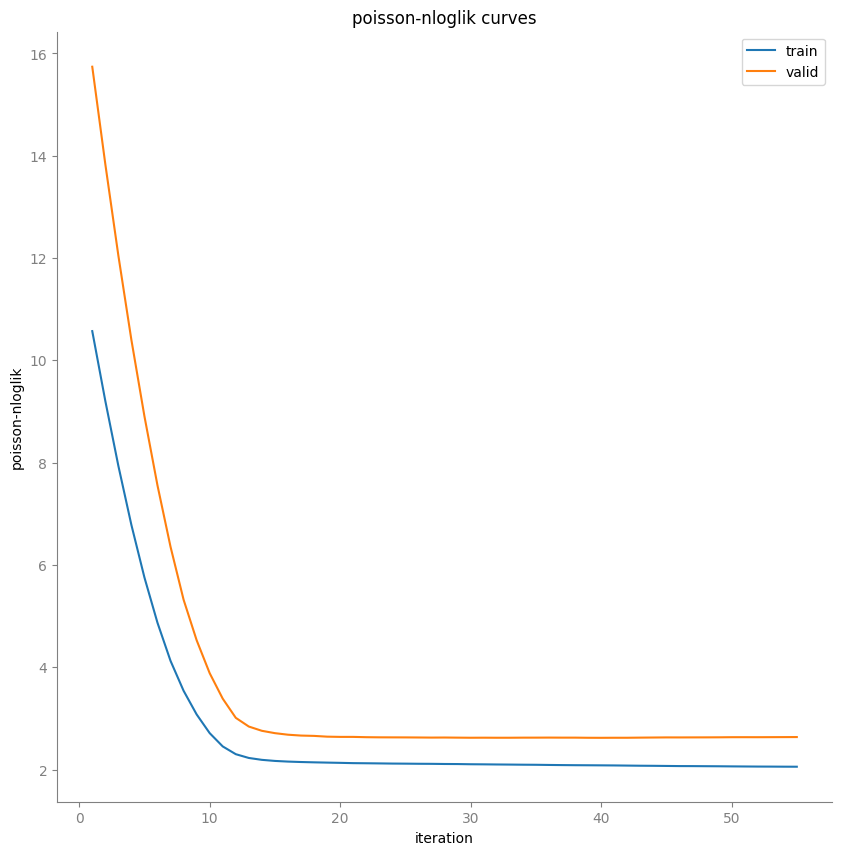

Train WMAPE: 42.47
Test WMAPE: 44.2
Train bias: -0.01
Test bias: -0.57


In [34]:
params_default = {
        'eta': 0.5,
        'max_depth': 5,
        'subsample': 0.9,
        'colsample_bytree': 0.7,

        'objective': 'count:poisson', 

        'booster': 'gbtree',
        'tree_method': 'hist',
        # 'max_bin': 30
    }

train_mask = (dataset_w_feats.index < VALID_SPLIT_DATE)
valid_mask = (dataset_w_feats.index >= VALID_SPLIT_DATE) & (dataset_w_feats.index < TEST_SPLIT_DATE)
test_mask = (dataset_w_feats.index >= TEST_SPLIT_DATE) & (dataset_w_feats.index <= END_DATE)

    
evals_result = {}
booster = xgboost.train(
    params=params_default,
    dtrain=xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]),
    evals=((xgboost.DMatrix(dataset_w_feats[train_mask][PREDICTORS], dataset_w_feats[train_mask][TARGET]), 'train'),
           (xgboost.DMatrix(dataset_w_feats[valid_mask][PREDICTORS], dataset_w_feats[valid_mask][TARGET]), 'valid')),
    evals_result=evals_result,
    num_boost_round=200,
    early_stopping_rounds = 15,
    verbose_eval = True)

fig, ax = plt.subplots(1, 1, figsize = (10, 10), facecolor='white')
plot_learning_curves(evals_result, 'poisson-nloglik', ax)
plt.show()

#### Predictions generation
dataset_w_feats.loc[:, 'prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range = (0, booster.best_iteration))

#### Errors analysis
dataset_w_feats.loc[:, 'error_diff'] = dataset_w_feats['prediction'] - dataset_w_feats['sales_qty']
dataset_w_feats.loc[:, 'abs_diff'] = np.abs(dataset_w_feats['prediction'] - dataset_w_feats['sales_qty'])

#wmape_train = dataset_w_feats[train_mask]['abs_diff'].sum()/dataset_w_feats[train_mask]['sales_qty'].sum()
#wmape_test = dataset_w_feats[test_mask]['abs_diff'].sum()/dataset_w_feats[test_mask]['sales_qty'].sum()
wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
wmape_test = wmape(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

bias_train = wbias(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
bias_test = wbias(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['prediction'])

print("Train WMAPE:", wmape_train)
print("Test WMAPE:", wmape_test)
print("Train bias:", bias_train)
print("Test bias:", bias_test)

In [54]:
booster.feature_names

['item_price',
 'lagged_sales_358d_14d_mean',
 'lagged_sales_372d_14d_mean',
 'lagged_sales_60d_7d_mean',
 'lagged_sales_35d_7d_mean',
 'year',
 'avg_weekday_1m',
 'lagged_sales_351d_14d_mean',
 'lagged_sales_379d_14d_mean',
 'lagged_sales_60d_14d_mean',
 'lagged_sales_90d_7d_mean',
 'lagged_sales_90d_14d_mean',
 'avg_weekday_yearly',
 'easter',
 'easter_monday',
 'christmas',
 'new_years_day',
 'new_years_eve',
 'sv_lovre',
 'prvi_maj',
 'days_to_sv_lovre_7',
 'days_since_sv_lovre_7',
 'days_to_new_years_day_7',
 'days_since_new_years_day_7',
 'days_to_christmas_7',
 'days_since_christmas_7']

# Model evaluation

## Analysis of forecast error and bias by visualising scores per iteration

In [35]:
res = pd.DataFrame(columns = ['iters', 'wmape_train', 'wmape_valid', 'bias_train', 'bias_valid'])
for i in [int(x) for x in np.linspace(0, booster.num_boosted_rounds(), int(booster.num_boosted_rounds()/3)).tolist()]:
    dataset_w_feats['prediction'] = booster.predict(xgboost.DMatrix(dataset_w_feats[PREDICTORS]), iteration_range=(0, i))
    wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
    wmape_valid = wmape(dataset_w_feats[valid_mask]['sales_qty'], dataset_w_feats[valid_mask]['prediction'])
    bias_train = wbias(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['prediction'])
    bias_valid = wbias(dataset_w_feats[valid_mask]['sales_qty'], dataset_w_feats[valid_mask]['prediction'])
    res = pd.concat([res, 
                     pd.DataFrame([[i, wmape_train, wmape_valid, bias_train, bias_valid]], 
                                  columns = ['iters', 'wmape_train', 'wmape_valid', 'bias_train', 'bias_valid'])]
                   )

<Figure size 1000x600 with 0 Axes>

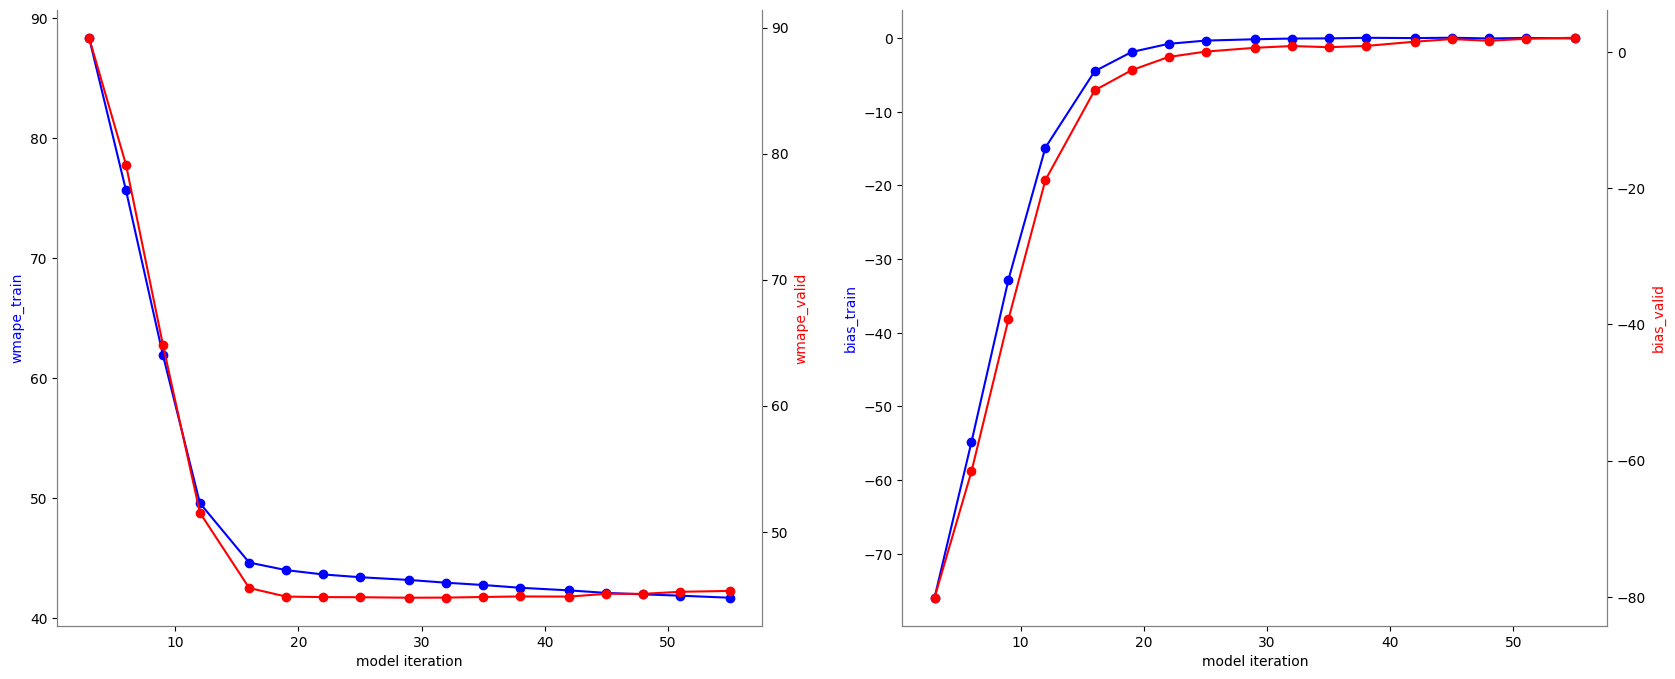

In [36]:
plt.figure(figsize=(10,6))
# plt.plot(res['iters'].iloc[1:], res['wmape_train'].iloc[1:], marker='o', color='blue')
# plt.ylabel('wmape_train', color='blue')
# plt.xlabel('model iteration')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax = axes[0]#plt.gca()
ax.plot(res['iters'].iloc[1:], res['wmape_train'].iloc[1:], marker='o', color='blue')
ax.set_ylabel('wmape_train', color='blue')
ax.set_xlabel('model iteration')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')

ax2 = ax.twinx()

ax2.plot(res['iters'].iloc[1:], res['wmape_valid'].iloc[1:], color='red', marker='o')
ax2.set_ylabel('wmape_valid', color='red')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_color('gray')
ax2.spines['left'].set_color('gray')
ax2.spines['bottom'].set_color('gray')

ax3 = axes[1]
ax3.plot(res['iters'].iloc[1:], res['bias_train'].iloc[1:], marker='o', color='blue')
ax3.set_ylabel('bias_train', color='blue')
ax3.set_xlabel('model iteration')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_color('gray')
ax3.spines['left'].set_color('gray')
ax3.spines['bottom'].set_color('gray')

ax4 = ax3.twinx()
ax4.plot(res['iters'].iloc[1:], res['bias_valid'].iloc[1:], color='red', marker='o')
ax4.set_ylabel('bias_valid', color='red')

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_color('gray')
ax4.spines['left'].set_color('gray')
ax4.spines['bottom'].set_color('gray')


plt.show()

## Feature importances

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


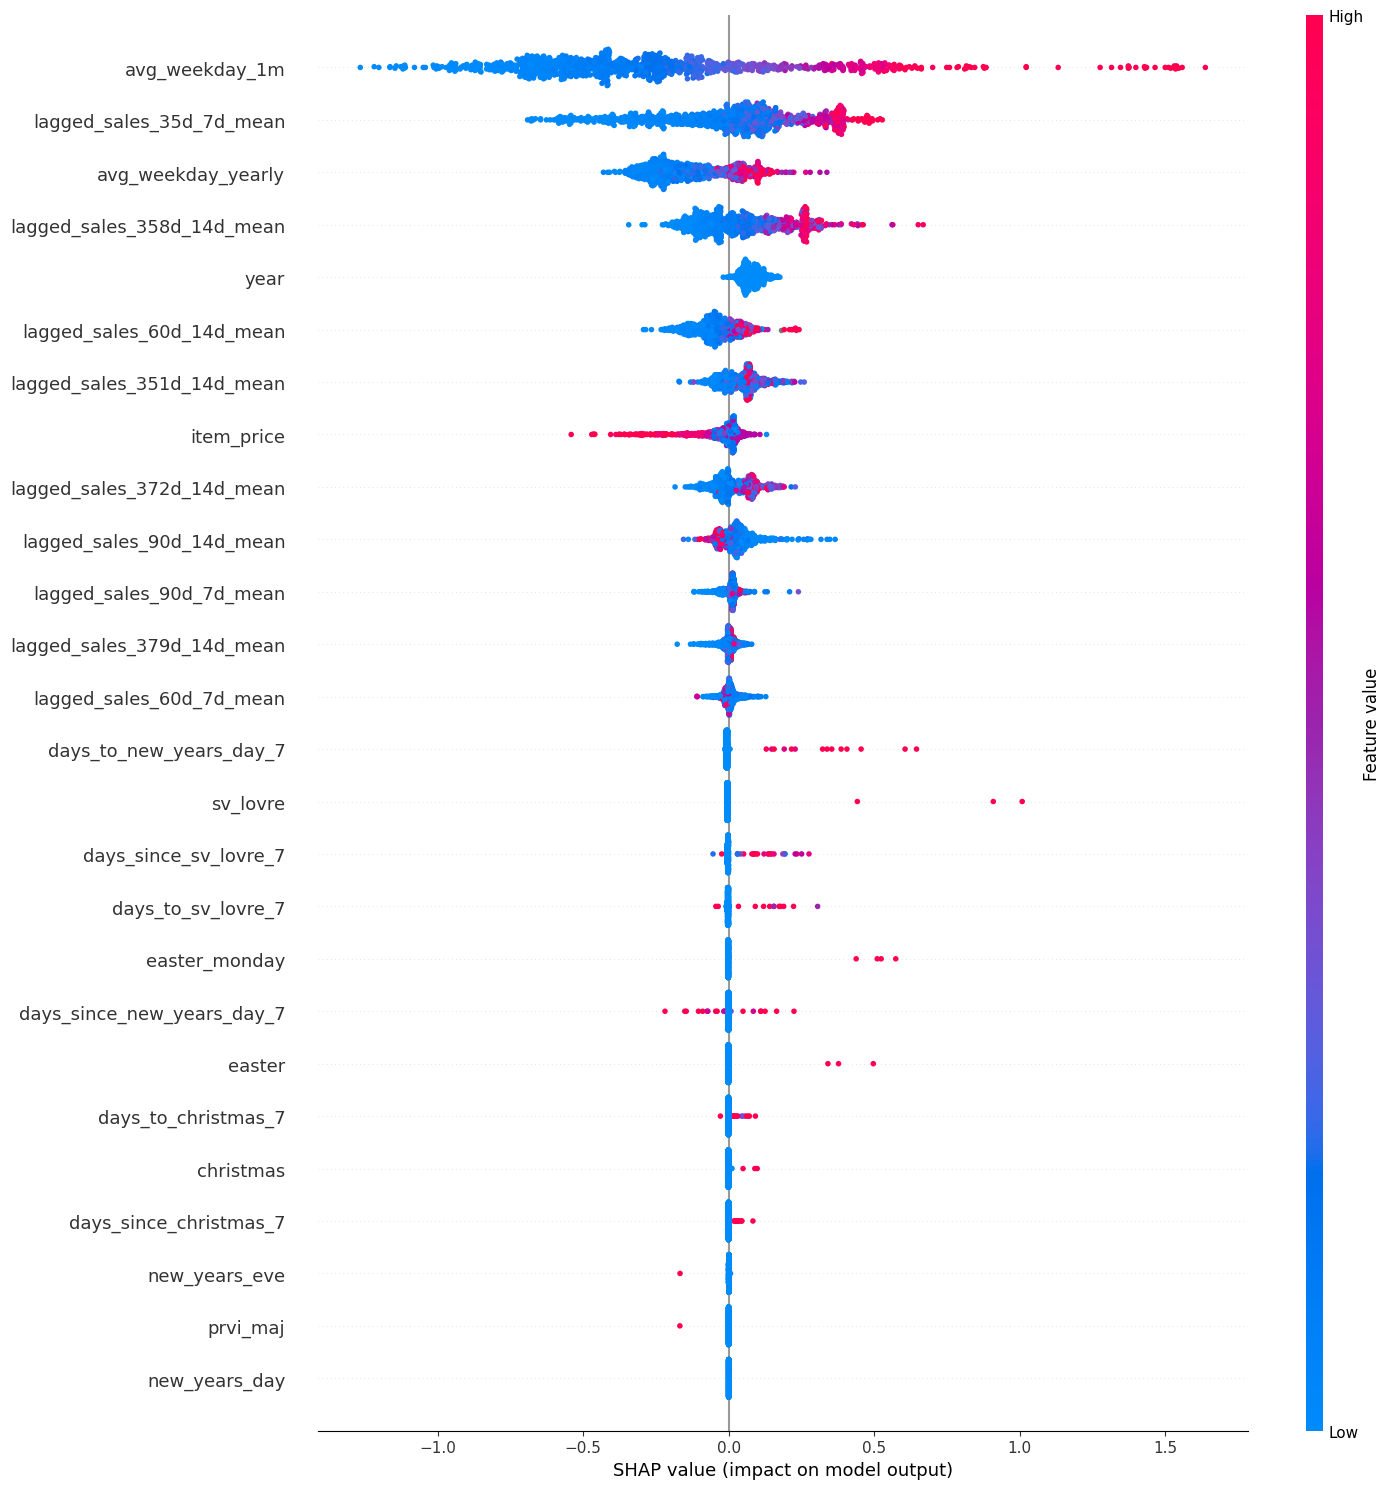

In [37]:
subsample_size = 1000

explainer = shap.TreeExplainer(booster)
predictors = booster.feature_names

df_sample = dataset_w_feats[valid_mask][predictors].sample(subsample_size)

shap_values = explainer(df_sample)

shap.summary_plot(shap_values.values, df_sample, max_display=60, show=True, plot_size=[15,15])
plt.show()

## Errors analysis

In [87]:
## Summary of results


# Train WMAPE: 44.89
# Test WMAPE: 43.96
# Train bias: -0.74
# Test bias: -5.26

### Without holidays indicators
# Train WMAPE: 45.89
# Test WMAPE: 45.91
# Train bias: -0.16
# Test bias: -4.0

### With holidays indicators
# Train WMAPE: 45.87
# Test WMAPE: 45.53
# Train bias: -1.07
# Test bias: -2.33

### With st. lovre
# Train WMAPE: 45.39
# Test WMAPE: 45.62
# Train bias: -0.05
# Test bias: -3.11

###
# Train WMAPE: 44.7
# Test WMAPE: 45.03
# Train bias: -0.14
# Test bias: -4.48

# Train WMAPE: 44.33
# Test WMAPE: 44.78
# Train bias: -0.03
# Test bias: -3.39

# Train WMAPE: 45.35
# Test WMAPE: 43.98
# Train bias: -0.55
# Test bias: -2.1

# Save model

In [61]:
if hasattr(booster, 'feature_names'): 
    booster.set_attr(feature_names = '|'.join(booster.feature_names))

In [59]:
'|'.join(booster.feature_names)

'item_price|lagged_sales_358d_14d_mean|lagged_sales_372d_14d_mean|lagged_sales_60d_7d_mean|lagged_sales_35d_7d_mean|year|avg_weekday_1m|lagged_sales_351d_14d_mean|lagged_sales_379d_14d_mean|lagged_sales_60d_14d_mean|lagged_sales_90d_7d_mean|lagged_sales_90d_14d_mean|avg_weekday_yearly|easter|easter_monday|christmas|new_years_day|new_years_eve|sv_lovre|prvi_maj|days_to_sv_lovre_7|days_since_sv_lovre_7|days_to_new_years_day_7|days_since_new_years_day_7|days_to_christmas_7|days_since_christmas_7'

In [62]:
MODELS_FOLDER = get_project_root() / 'models'
MODEL_NAME = 'xgb_caffe_bar_demand_forecast_v1.bst'
MODELS_SAVE_PATH = MODELS_FOLDER / MODEL_NAME
# if not os.path.isdir(MODELS_FOLDER / MODEL_NAME):
#    os.makedirs(MODELS_FOLDER / MODEL_NAME)
booster.save_model(MODELS_SAVE_PATH)

# Save datasets

In [43]:
DATASETS_FOLDER = get_project_root() / 'data/processed'
TRAIN_DATASET_PATH = DATASETS_FOLDER / 'train_data.pkl'
VALID_DATASET_PATH = DATASETS_FOLDER / 'valid_data.pkl'
TEST_DATASET_PATH = DATASETS_FOLDER / 'test_data.pkl'

In [44]:
dataset_w_feats[train_mask].to_pickle(TRAIN_DATASET_PATH)
dataset_w_feats[valid_mask].to_pickle(VALID_DATASET_PATH)
dataset_w_feats[test_mask].to_pickle(TEST_DATASET_PATH)

# Visualisation of scores

In [99]:

wmape_train_valid_scores = dataset_w_feats[train_mask | valid_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                               'total_sales': x['sales_qty'].sum(),
                                                               'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()
wmape_test_scores = dataset_w_feats[test_mask].groupby('item_name').apply(lambda x: pd.Series({'bias': wbias(x['sales_qty'], x['prediction']), 
                                                                'wmape': wmape(x['sales_qty'], x['prediction']),
                                                                'total_sales': x['sales_qty'].sum(),
                                                                'total_prediction': x['prediction'].sum()})
                                                                ).sort_values(by='total_sales', ascending=False).reset_index()

(0.0, 217.1945)

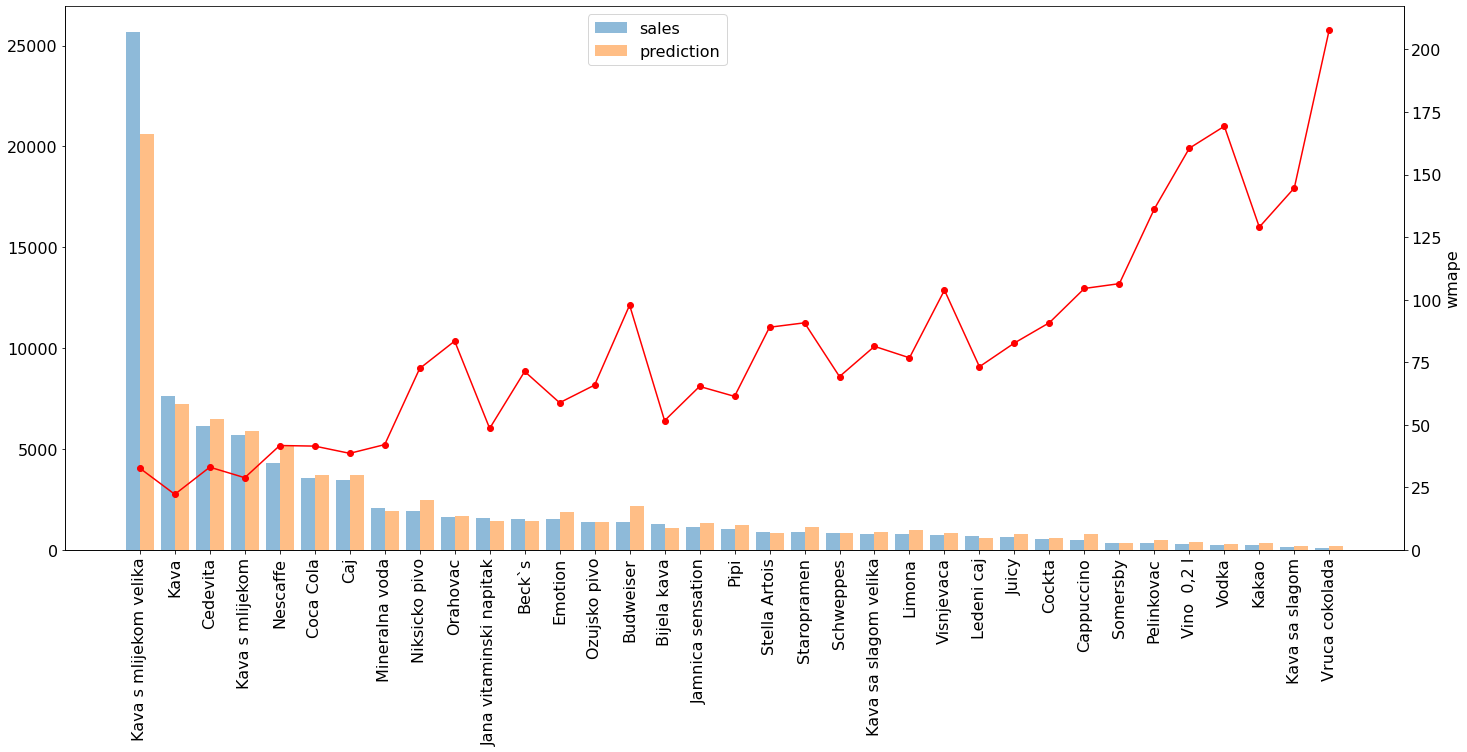

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(24,10))

X_axis = np.arange(len(wmape_test_scores['item_name']))
p1 = ax.bar(X_axis - 0.2, wmape_test_scores['total_sales'], width=0.4, alpha=0.5, label='sales')
p2 = ax.bar(X_axis + 0.2, wmape_test_scores['total_prediction'], width=0.4, alpha=0.5, label='prediction')
ax.spines['top'].set_visible(False)
ax.set_xticks(X_axis)
ax.set_xticklabels(wmape_test_scores['item_name'], rotation=90, fontsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(bbox_to_anchor=(0.5, 1), fontsize=16)

ax2 = ax.twinx()
p3 = ax2.plot(X_axis, wmape_test_scores['wmape'], color = 'red', marker='o', label='wmape')
ax2.set_ylabel('wmape', fontsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylim([0, ax2.get_ylim()[1]])


In [128]:
dataset_w_feats.columns

Index(['item_name', 'sales_qty', 'item_price', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'month_of_year_1', 'month_of_year_2',
       'month_of_year_3', 'month_of_year_4', 'month_of_year_5',
       'month_of_year_6', 'month_of_year_7', 'month_of_year_8',
       'month_of_year_9', 'month_of_year_10', 'month_of_year_11', 'year',
       'first_third_of_month', 'second_third_of_month', 'last_third_of_month',
       'closed', 'easter', 'easter_monday', 'christmas', 'new_years_day',
       'new_years_eve', 'lagged_sales_358d_14d_mean',
       'lagged_sales_351d_14d_mean', 'lagged_sales_372d_14d_mean',
       'lagged_sales_379d_14d_mean', 'lagged_sales_365d_14d_mean',
       'lagged_sales_35d_7d_mean', 'lagged_sales_60d_7d_mean',
       'lagged_sales_60d_14d_mean', 'lagged_sales_90d_7d_mean',
       'lagged_sales_90d_14d_mean', 'month', 'day_of_week', 'avg_weekday_1m',
       'avg_weekday_yearly', 'sv_lovre', 'prvi_maj'

#### Item: Kava s mlijekom velika ####
## Train & valid scores: 
WMAPE: 19.72
Bias: -2.7
## Test scores: 
WMAPE: 32.66
Bias: -19.72


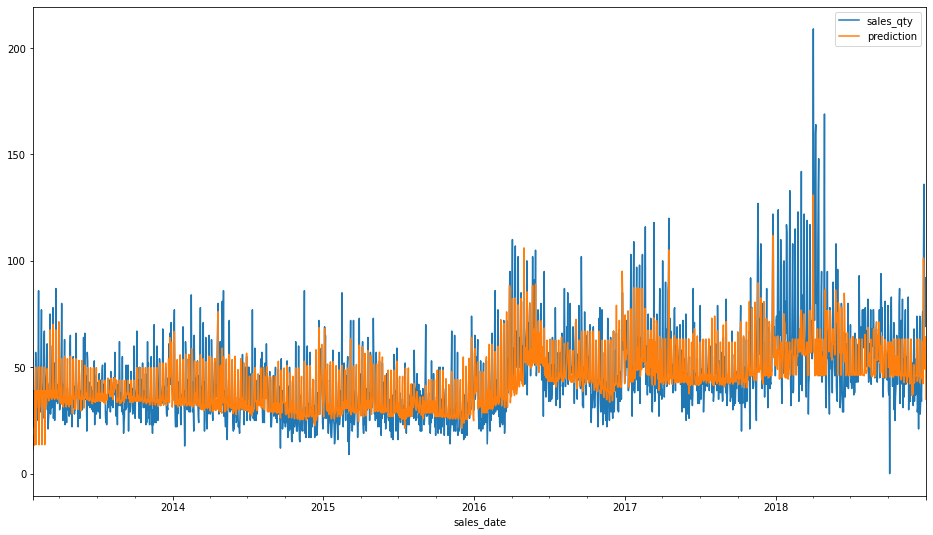

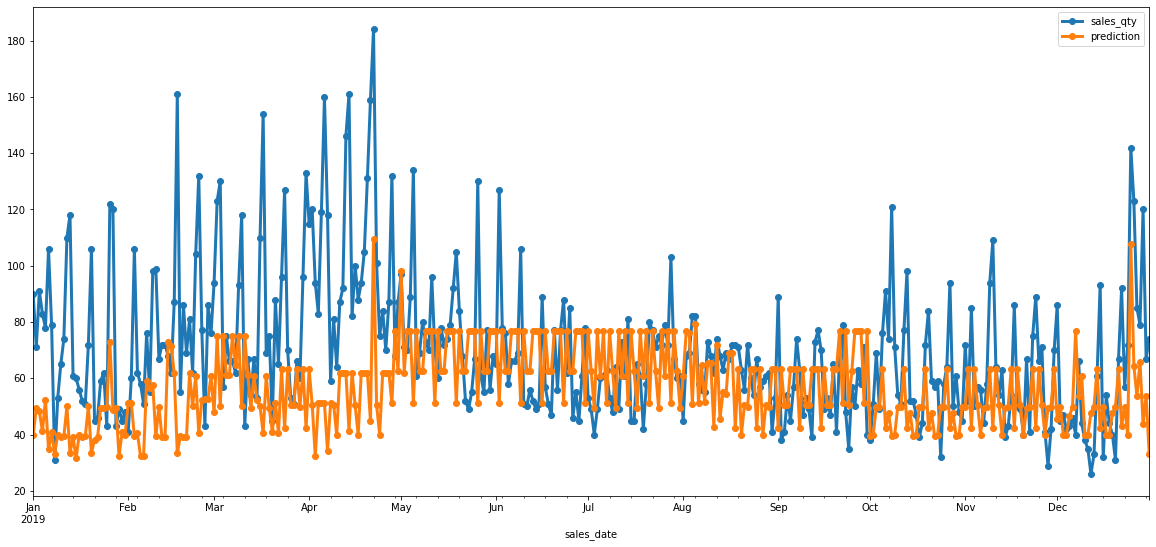

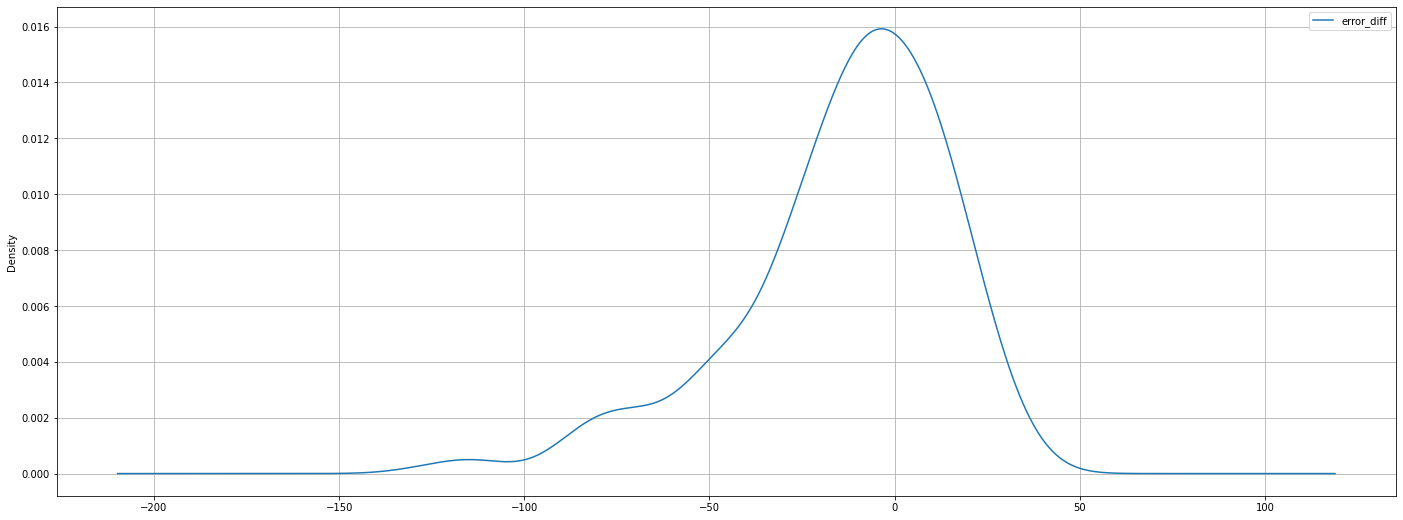

#### Item: Kava ####
## Train & valid scores: 
WMAPE: 25.03
Bias: 0.31
## Test scores: 
WMAPE: 22.22
Bias: -4.96


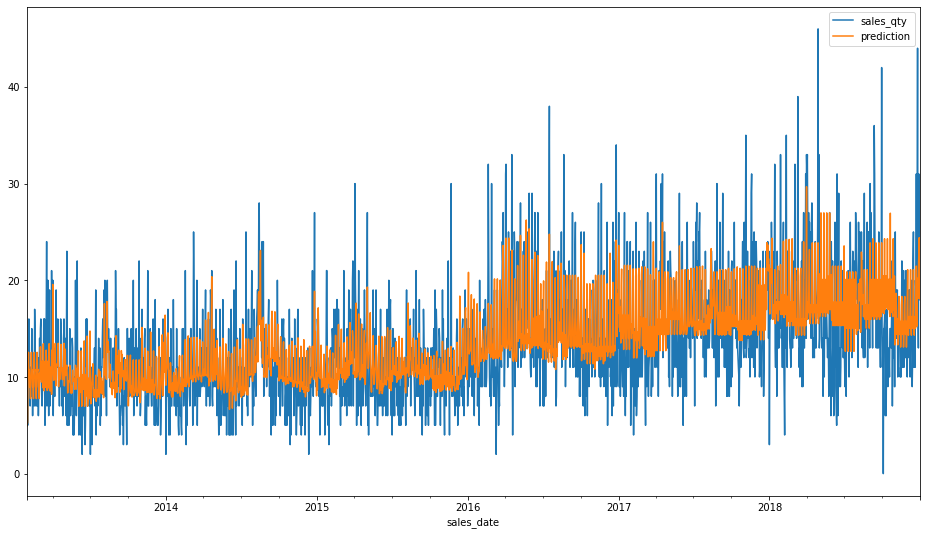

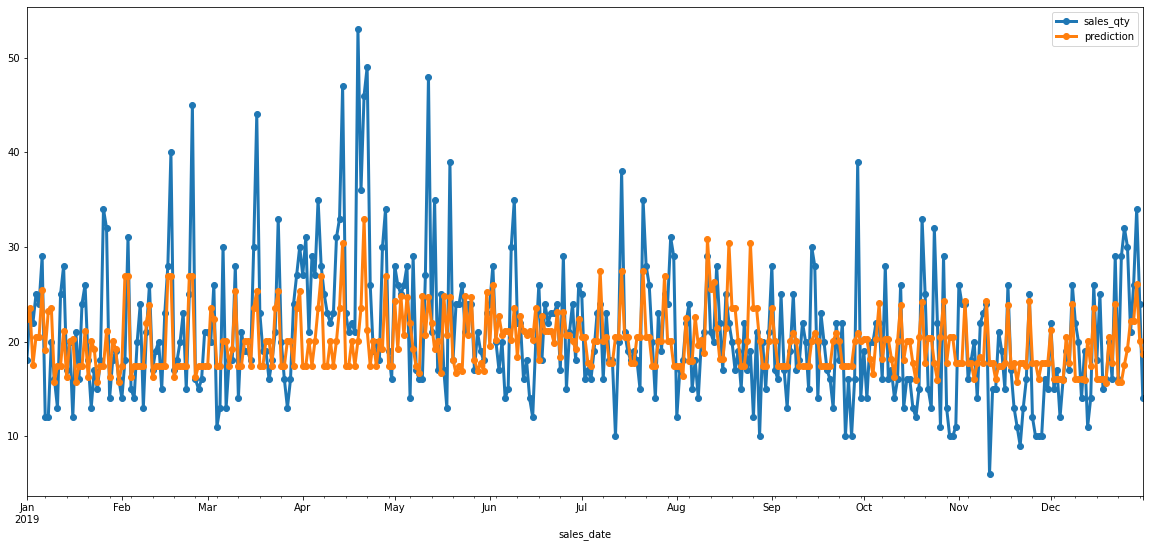

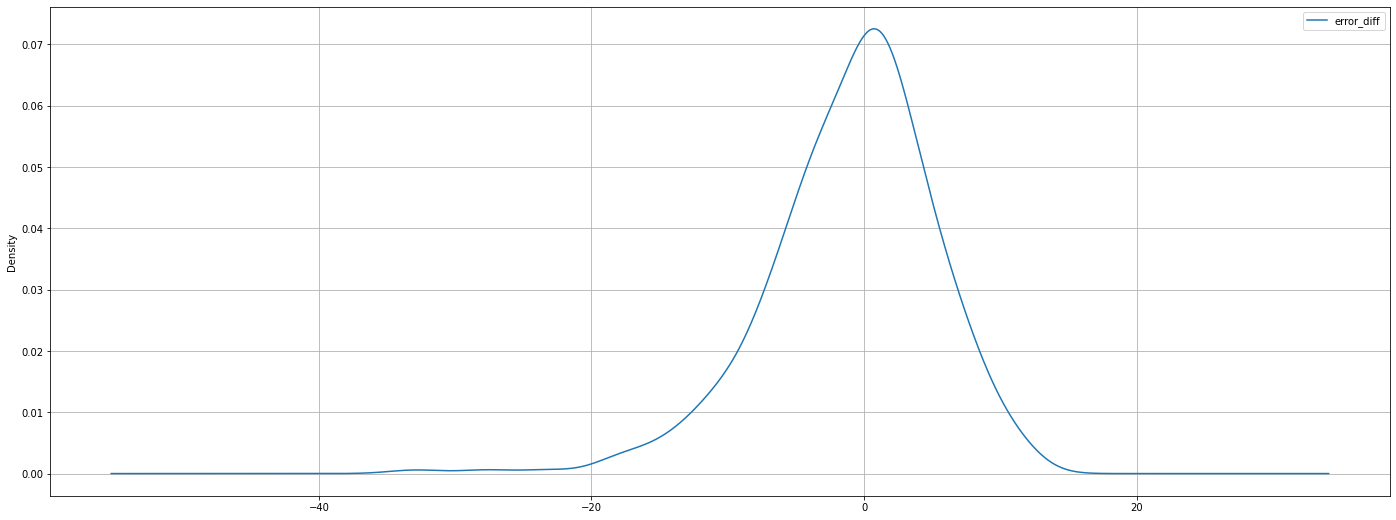

#### Item: Cedevita ####
## Train & valid scores: 
WMAPE: 35.04
Bias: -5.16
## Test scores: 
WMAPE: 33.07
Bias: 5.69


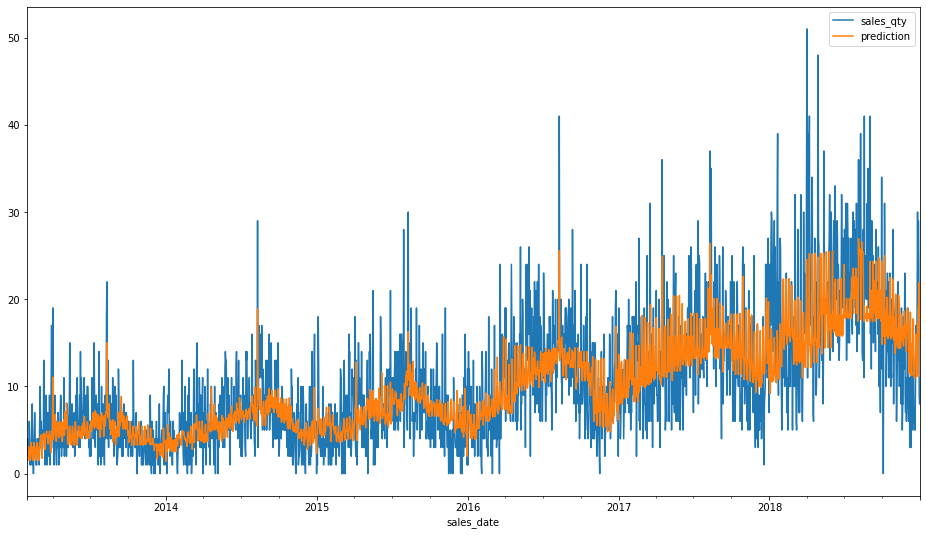

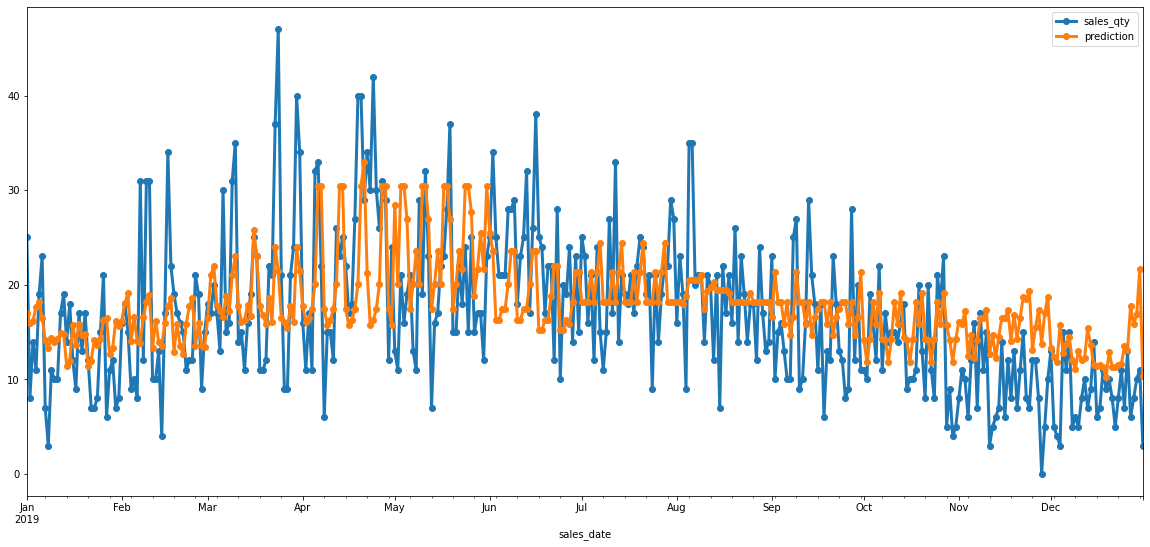

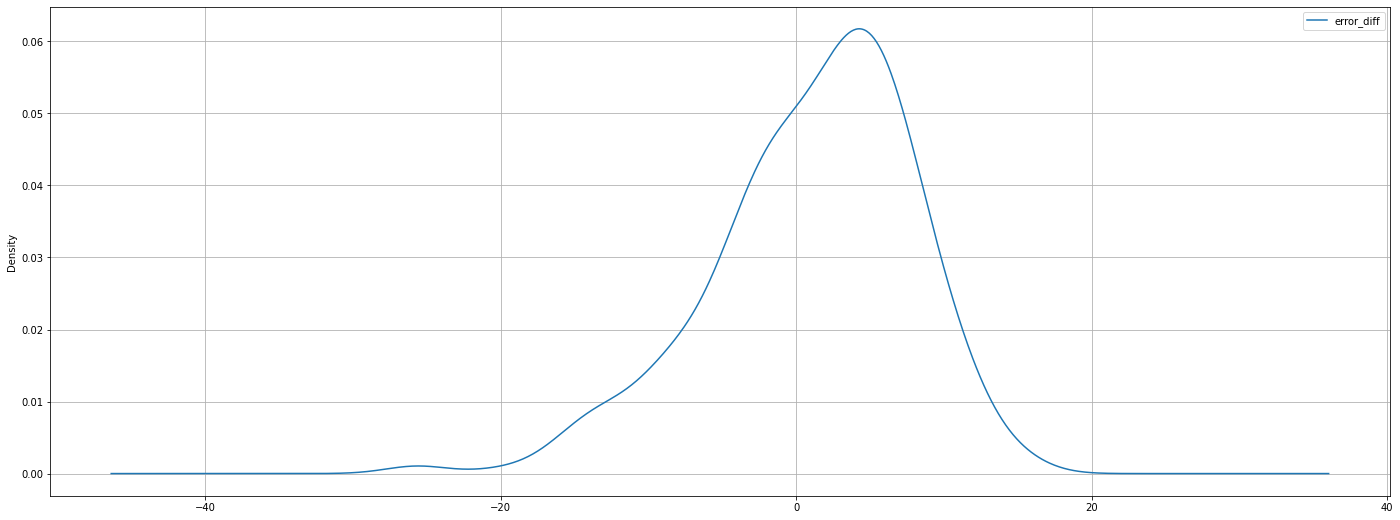

#### Item: Nescaffe ####
## Train & valid scores: 
WMAPE: 34.36
Bias: 0.97
## Test scores: 
WMAPE: 41.72
Bias: 19.93


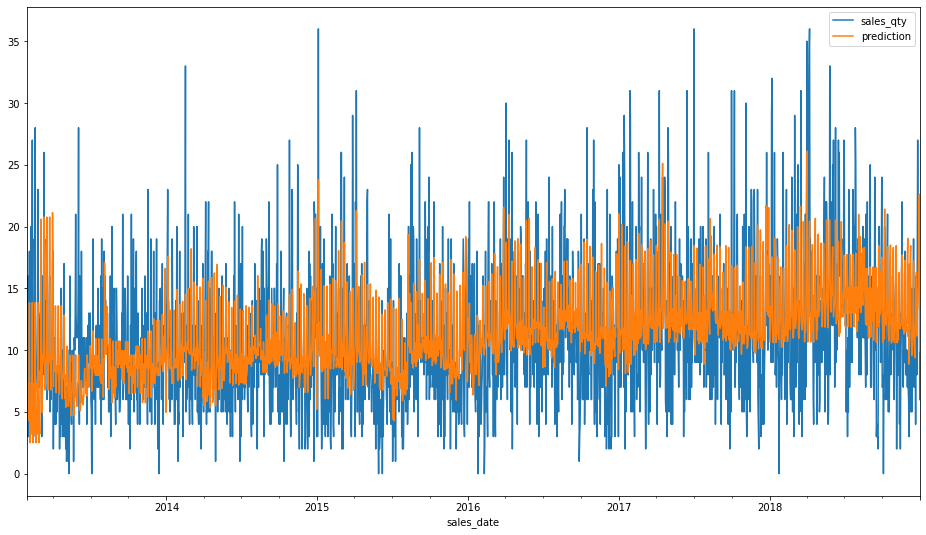

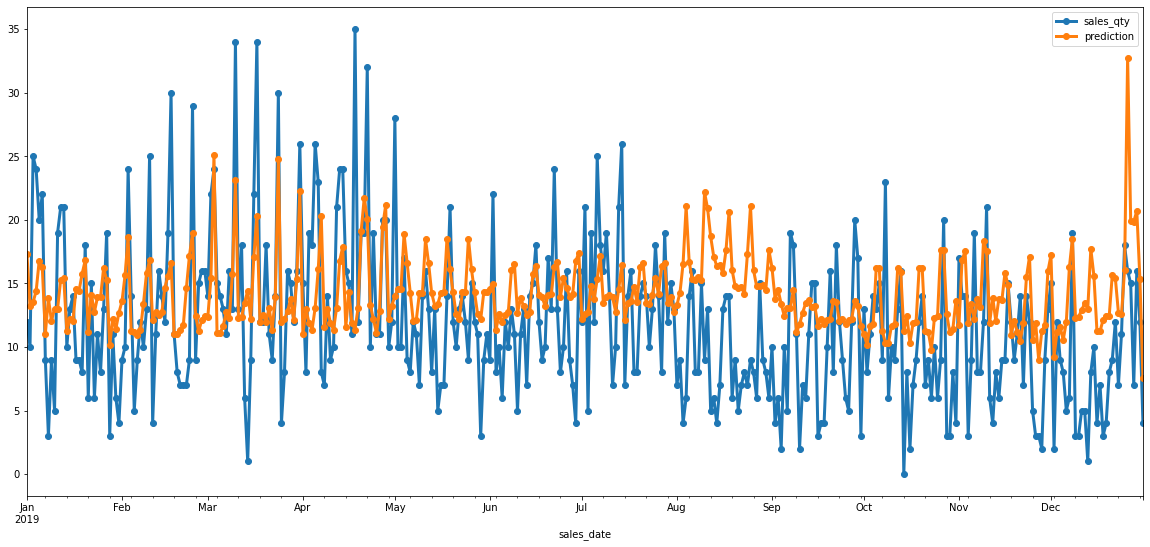

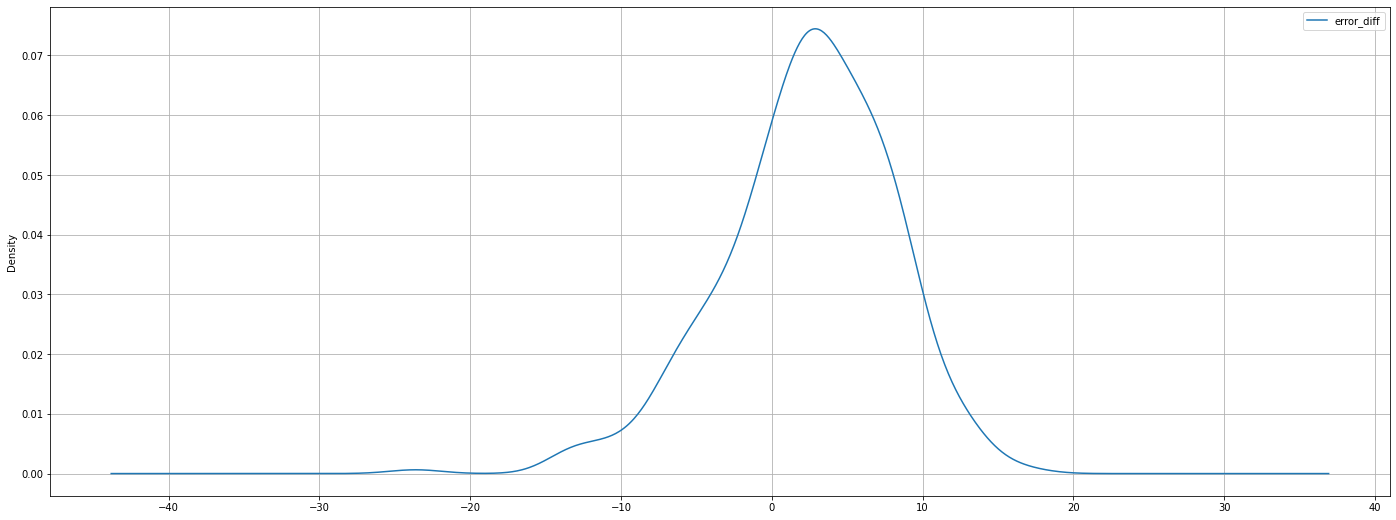

#### Item: Kava s mlijekom ####
## Train & valid scores: 
WMAPE: 32.83
Bias: 2.9
## Test scores: 
WMAPE: 28.86
Bias: 3.59


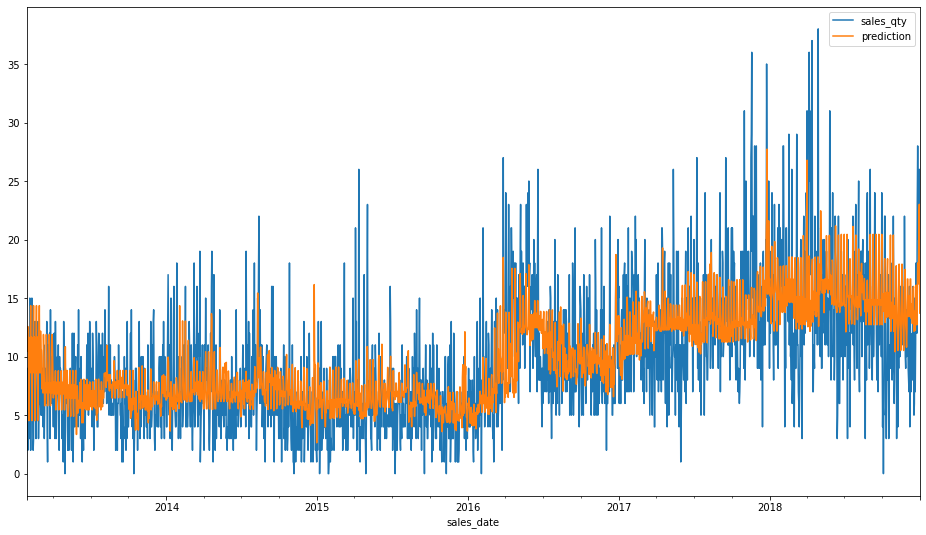

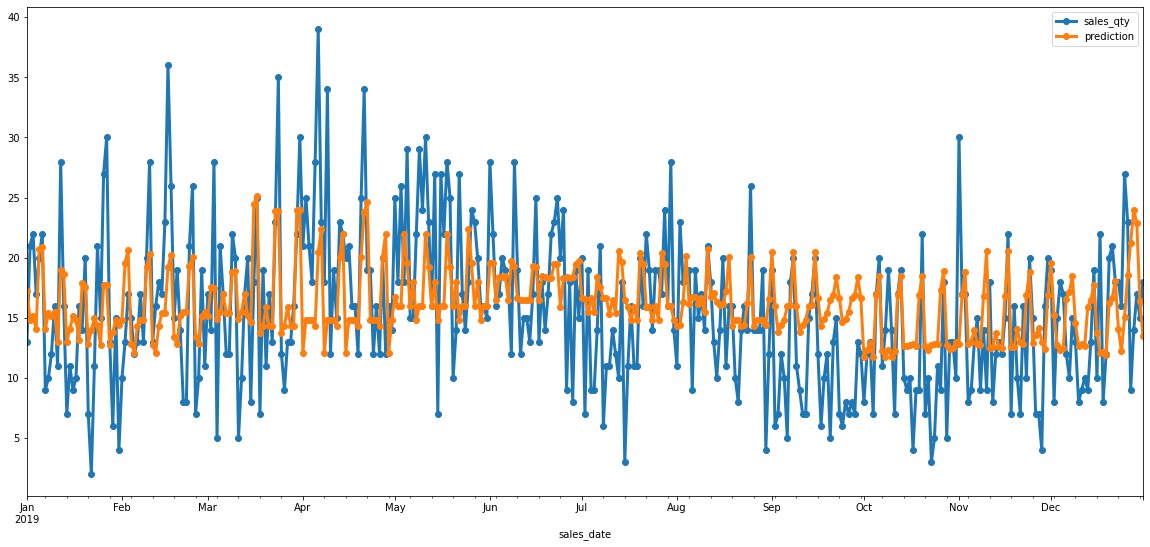

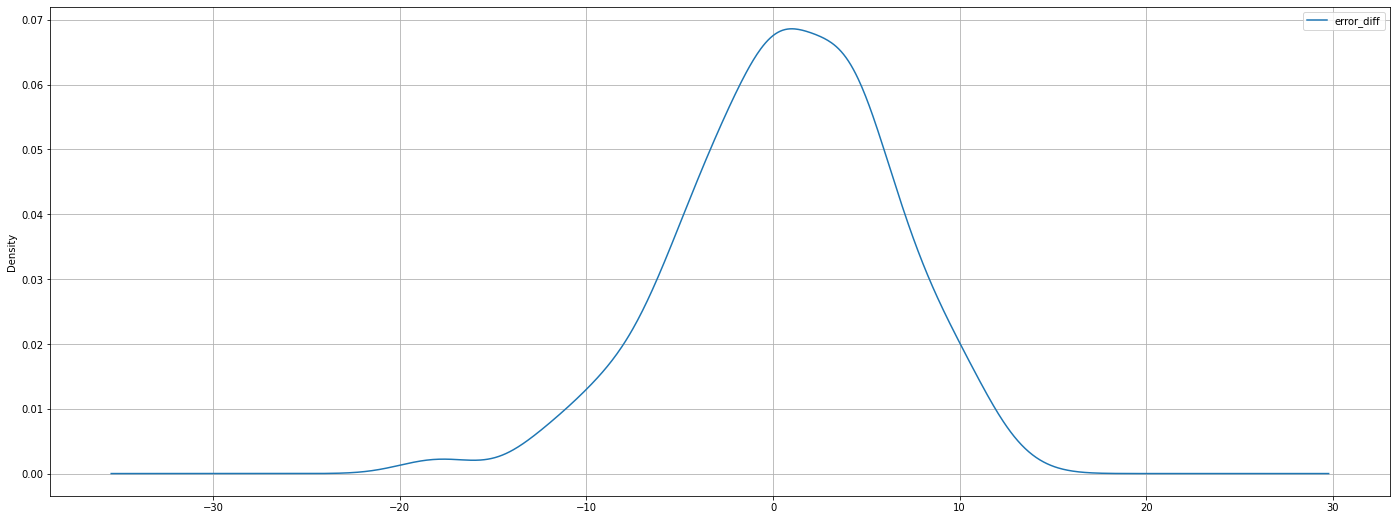

#### Item: Coca Cola ####
## Train & valid scores: 
WMAPE: 51.92
Bias: 0.12
## Test scores: 
WMAPE: 41.48
Bias: 3.73


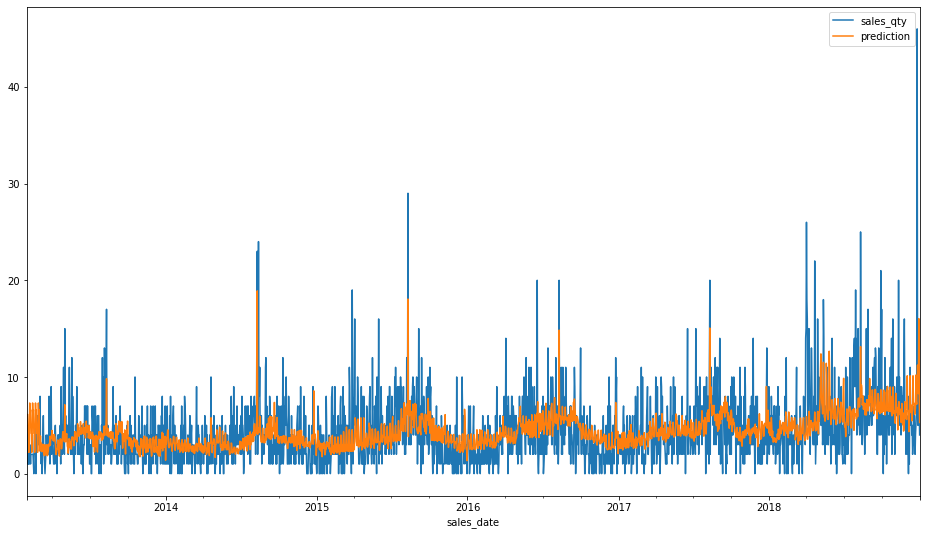

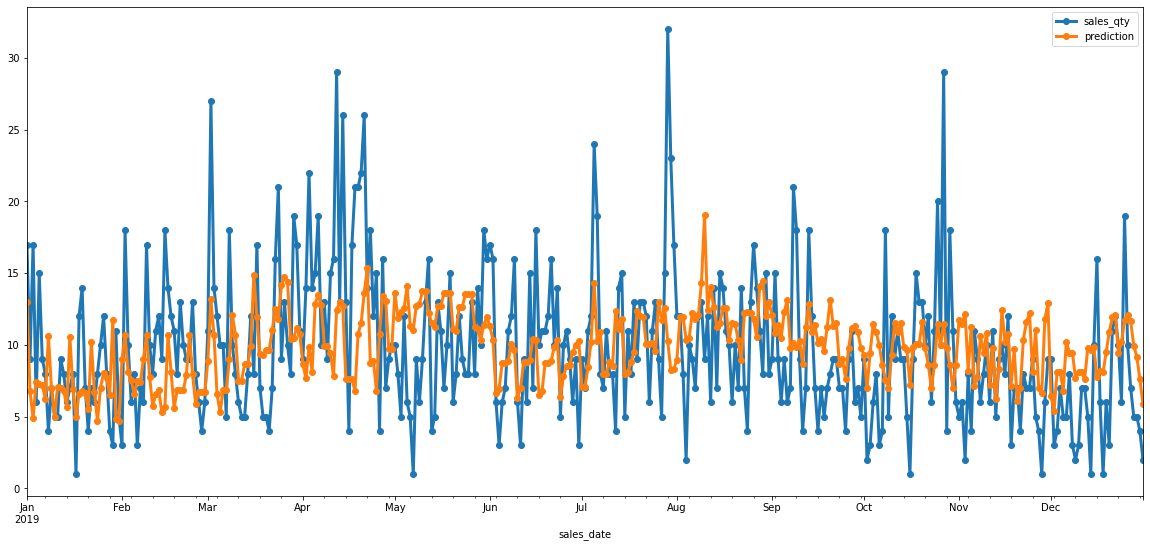

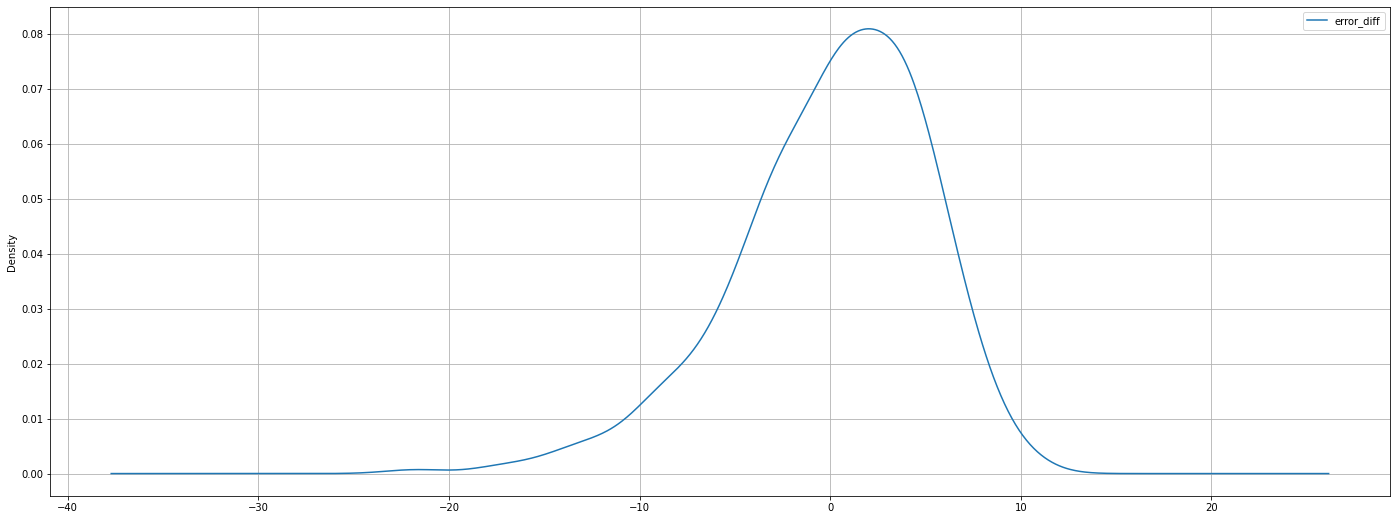

#### Item: Caj ####
## Train & valid scores: 
WMAPE: 41.52
Bias: 1.48
## Test scores: 
WMAPE: 38.59
Bias: 7.46


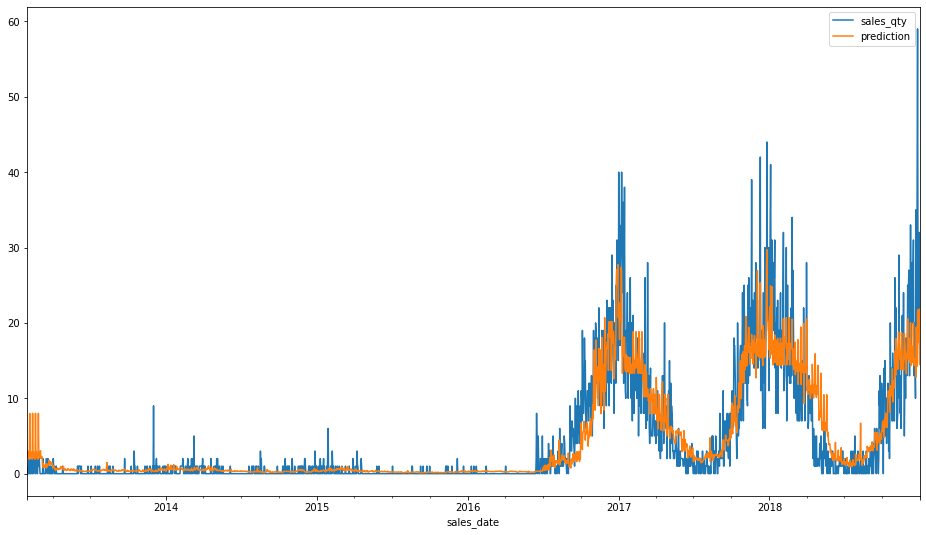

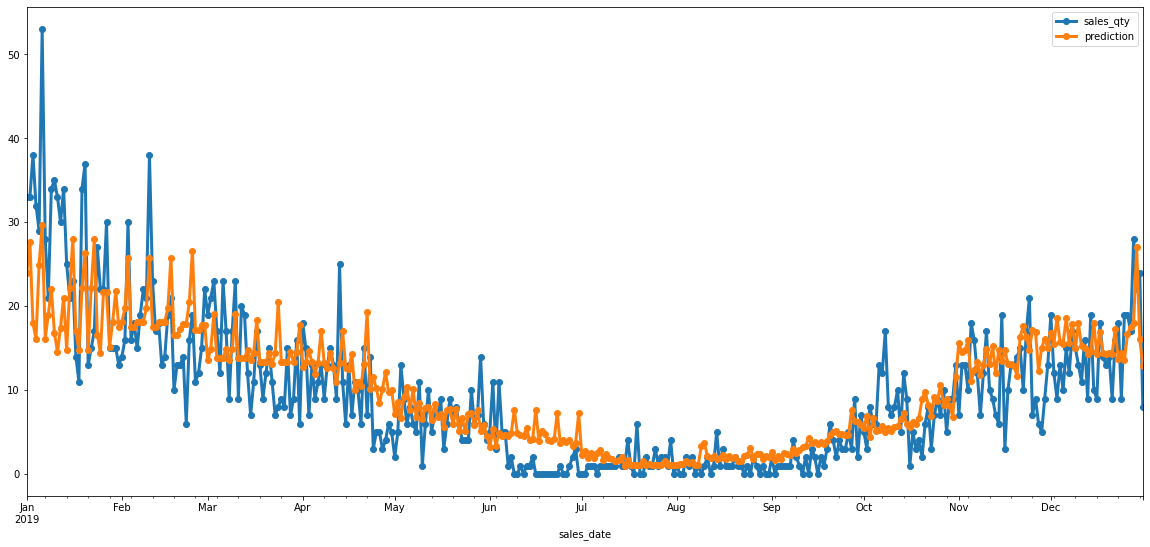

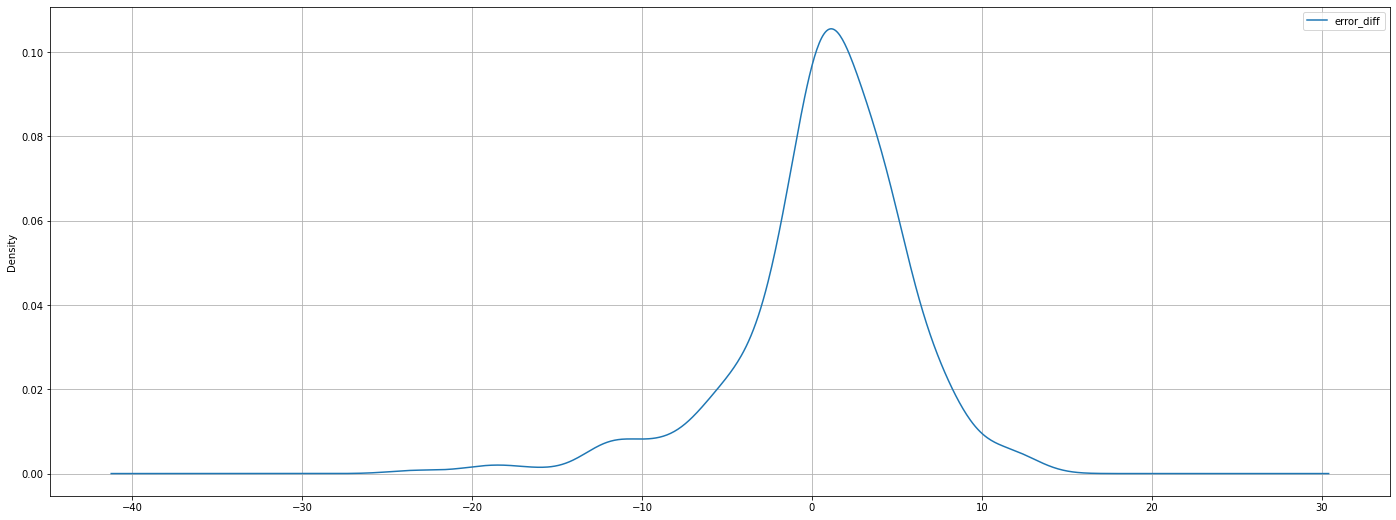

#### Item: Budweiser ####
## Train & valid scores: 
WMAPE: 62.23
Bias: 4.09
## Test scores: 
WMAPE: 97.81
Bias: 55.92


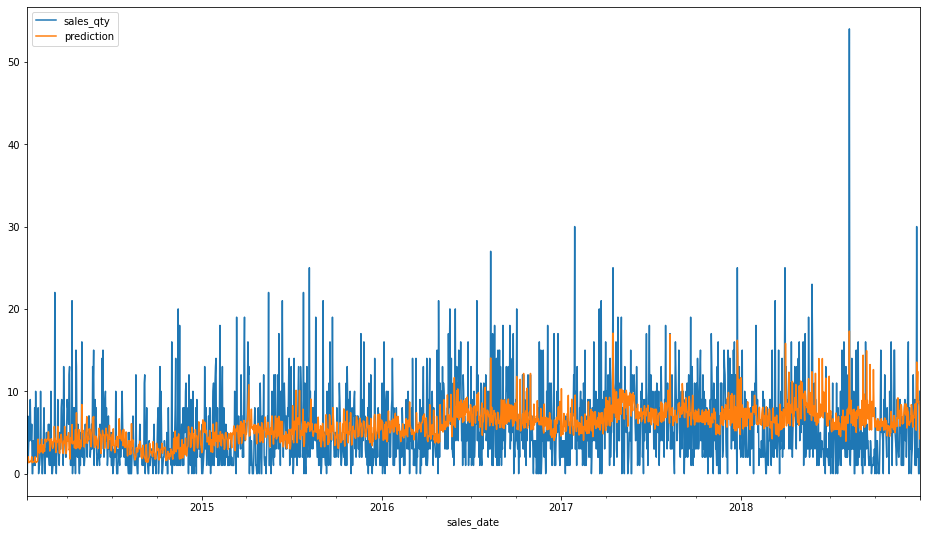

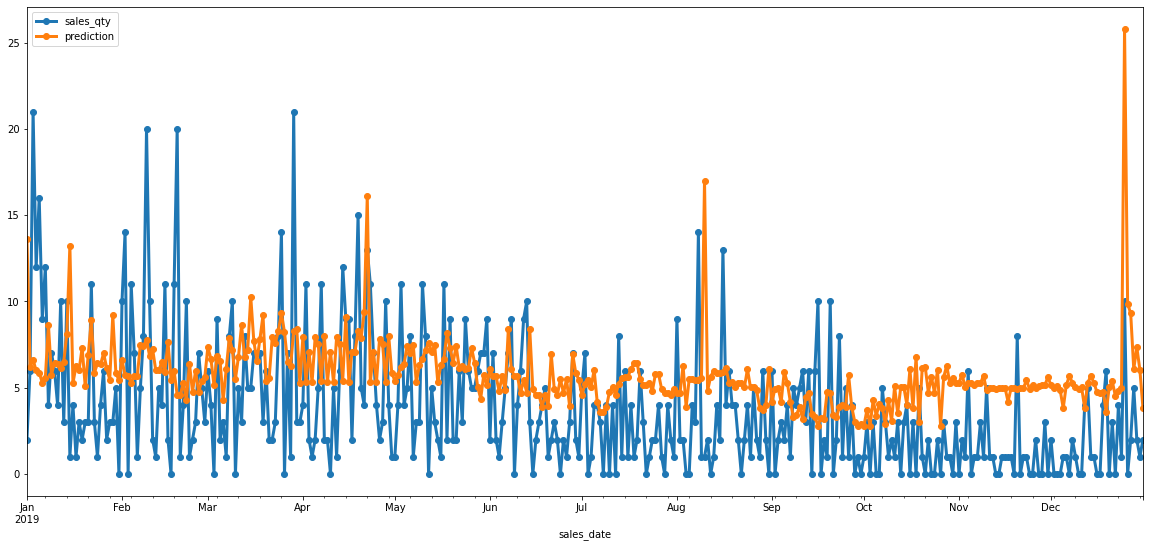

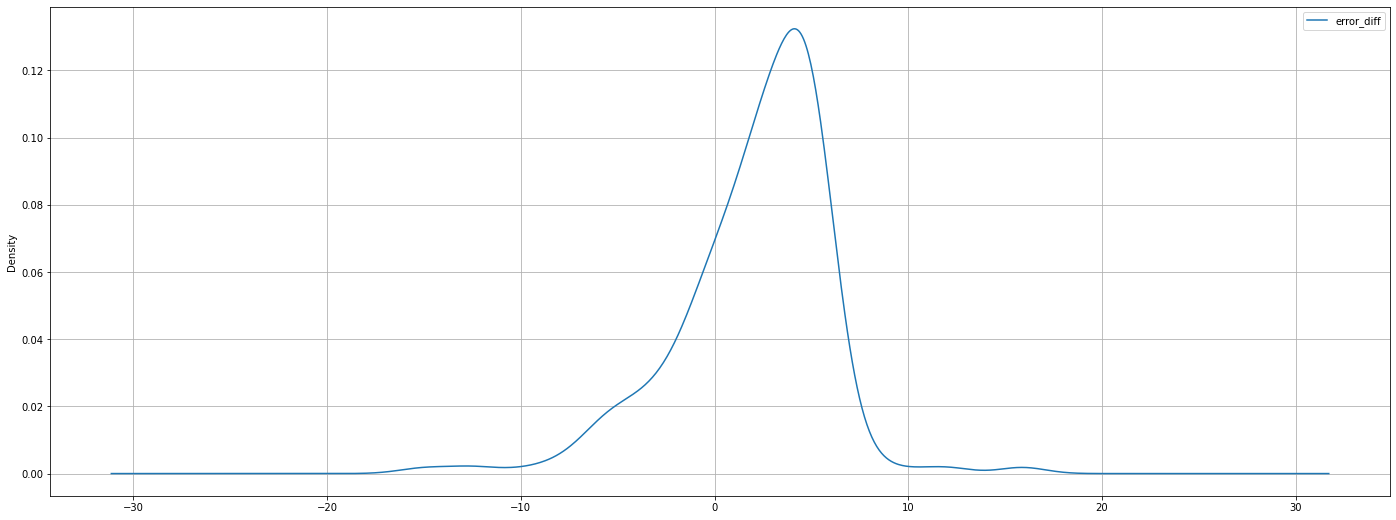

#### Item: Jamnica sensation ####
## Train & valid scores: 
WMAPE: 49.13
Bias: 8.97
## Test scores: 
WMAPE: 65.33
Bias: 15.73


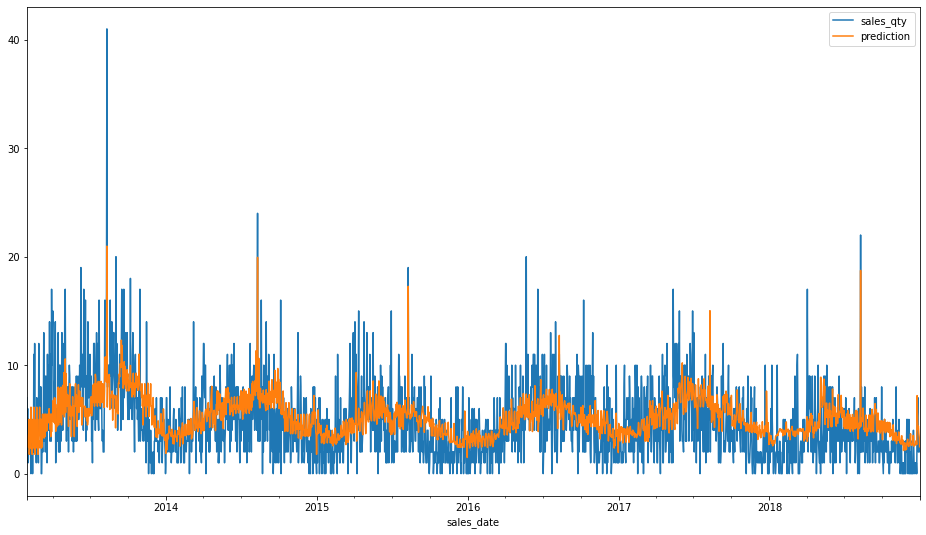

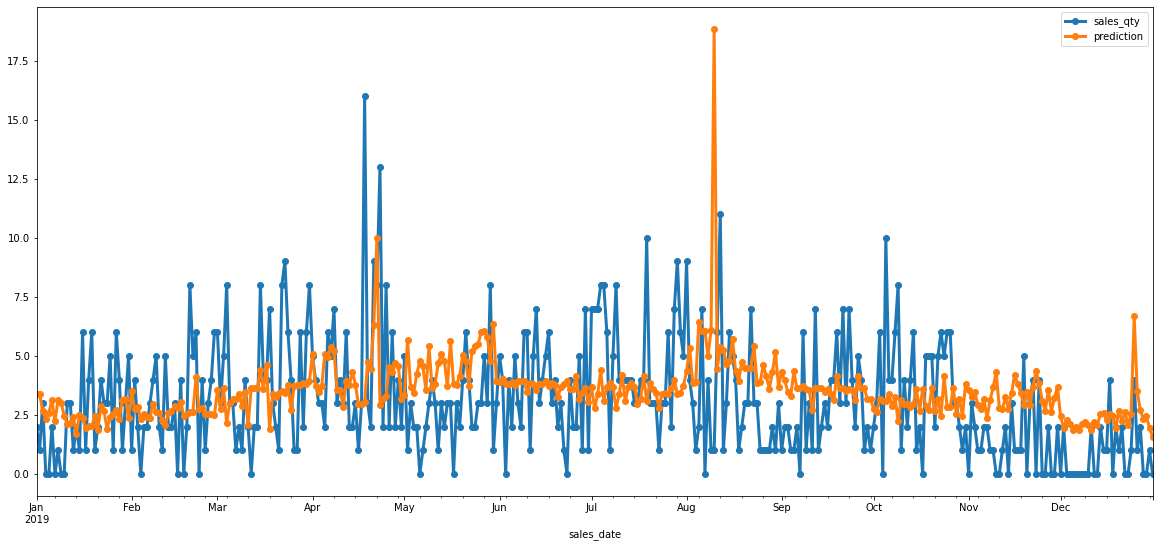

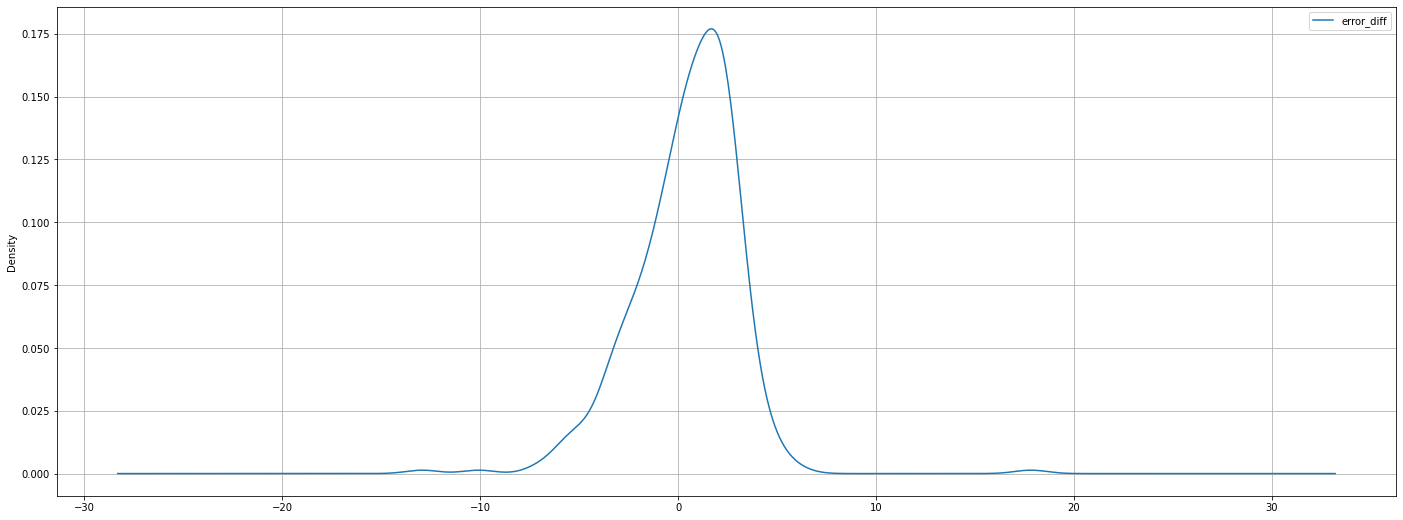

#### Item: Mineralna voda ####
## Train & valid scores: 
WMAPE: 51.75
Bias: -2.6
## Test scores: 
WMAPE: 42.08
Bias: -6.13


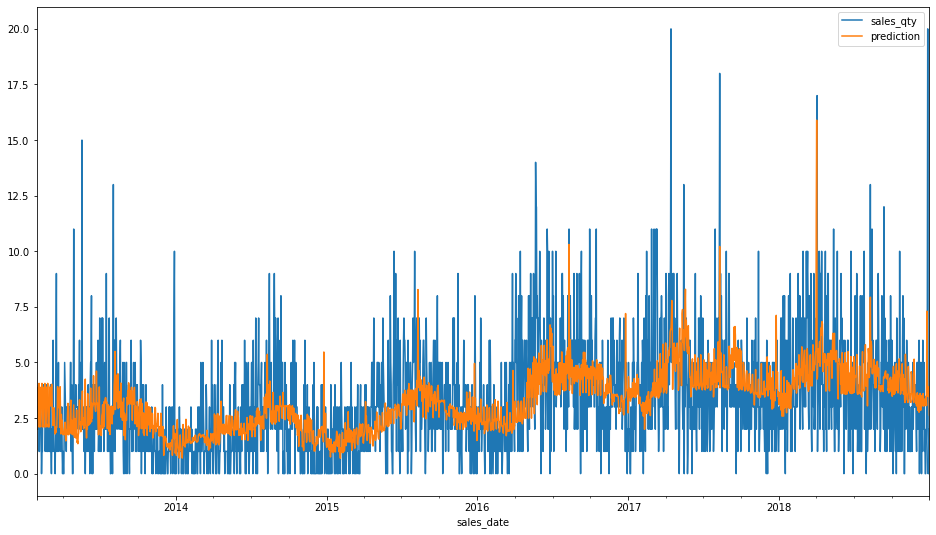

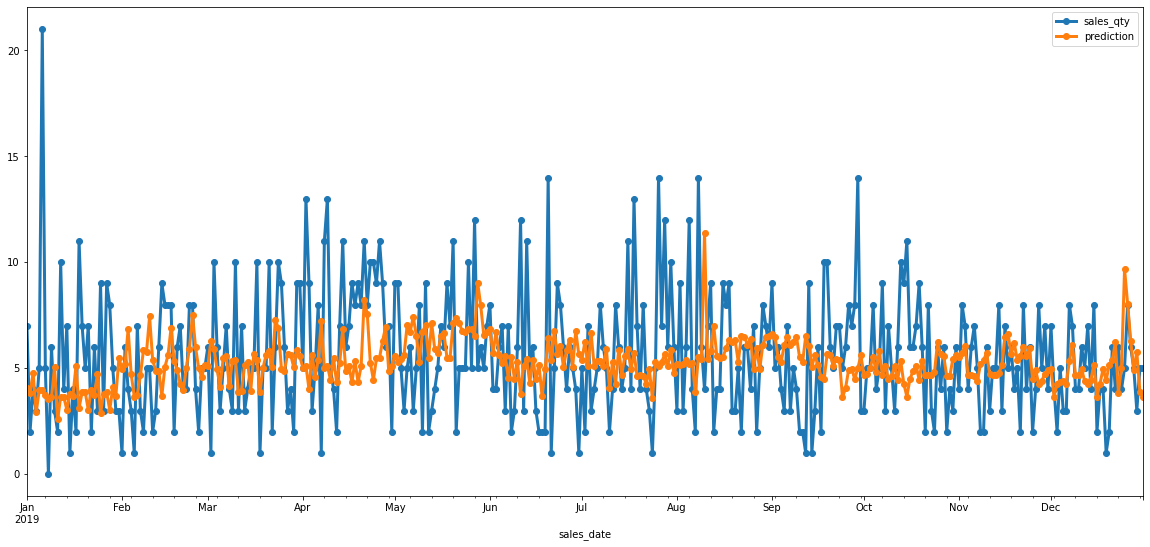

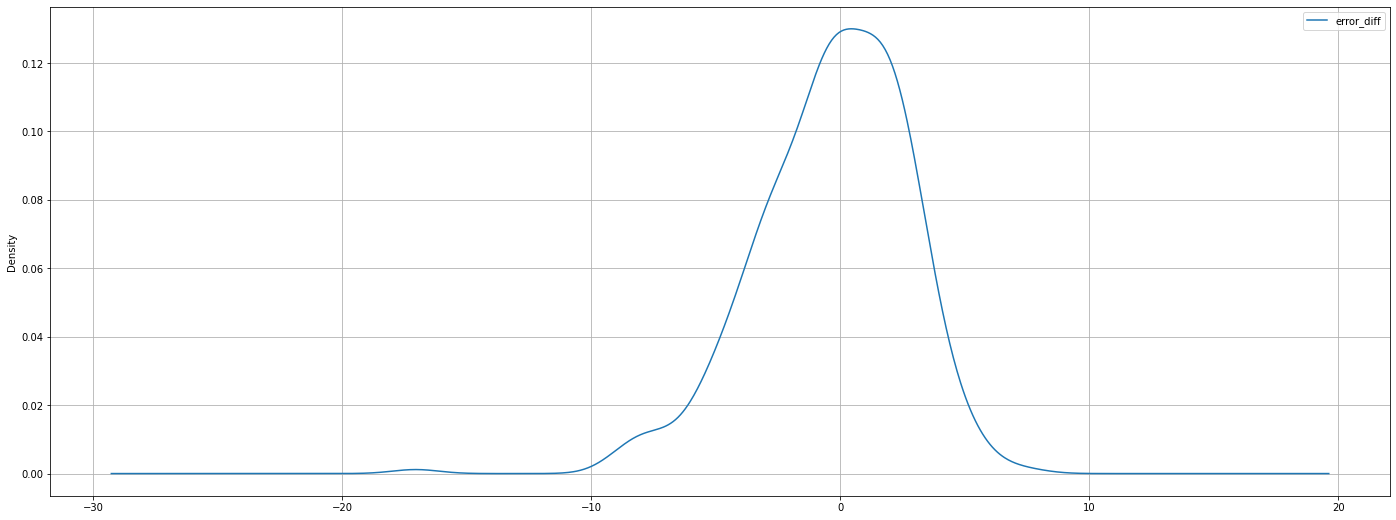

#### Item: Kava sa slagom velika ####
## Train & valid scores: 
WMAPE: 53.36
Bias: 6.78
## Test scores: 
WMAPE: 81.34
Bias: 9.23


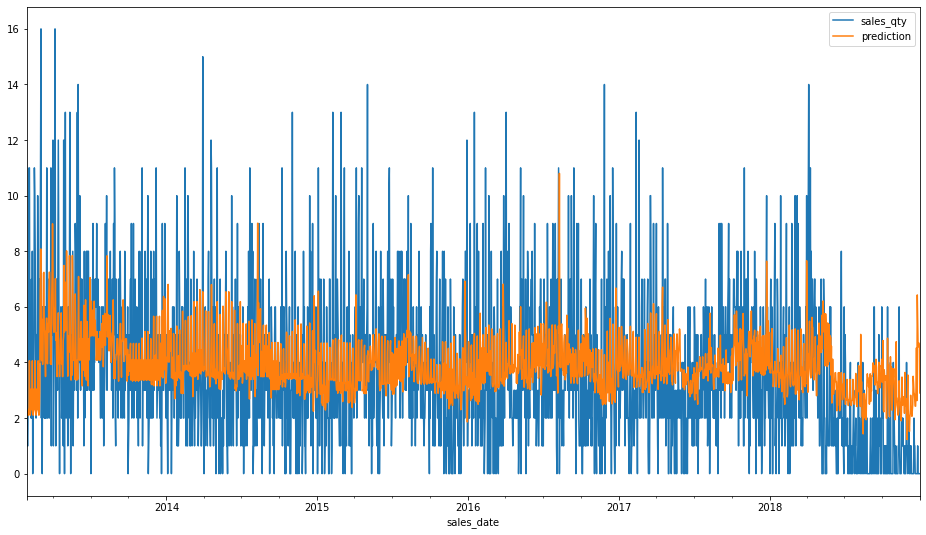

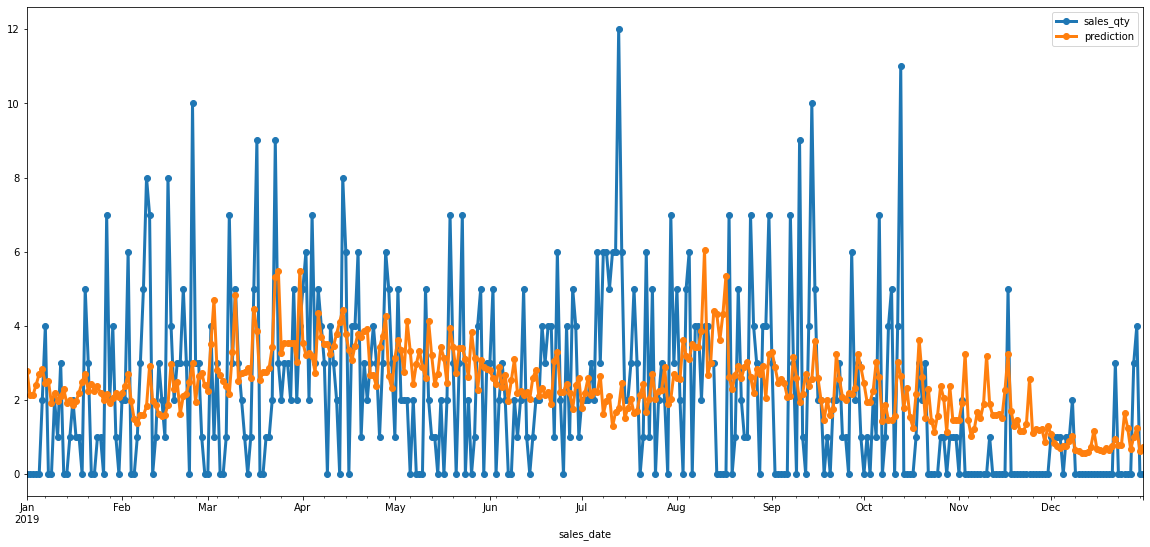

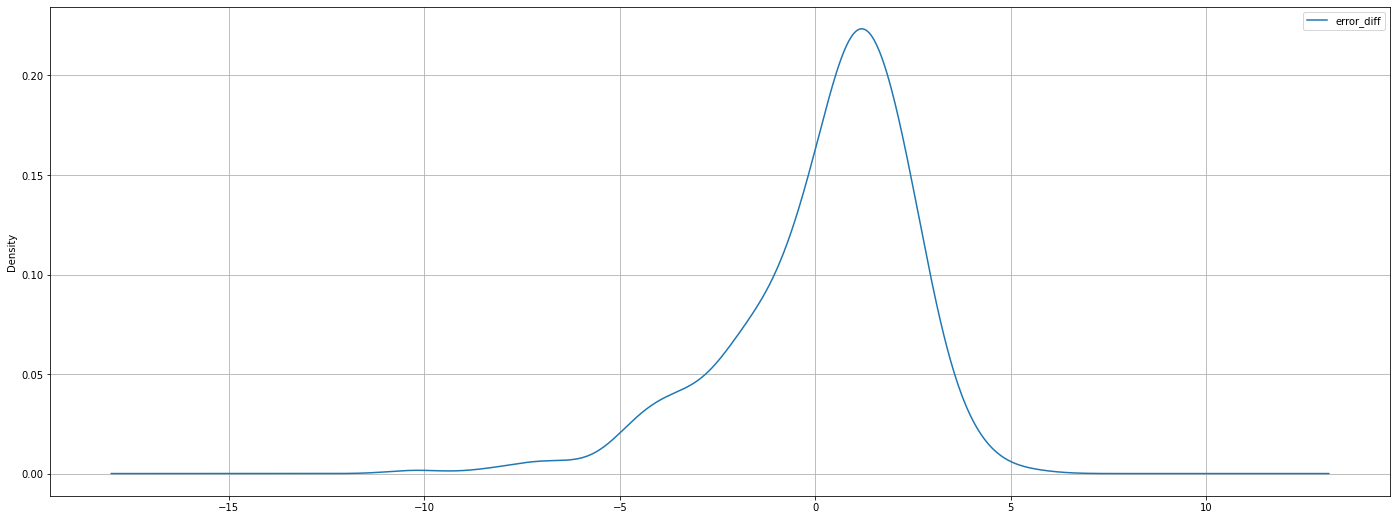

#### Item: Emotion ####
## Train & valid scores: 
WMAPE: 57.91
Bias: 5.01
## Test scores: 
WMAPE: 58.81
Bias: 20.49


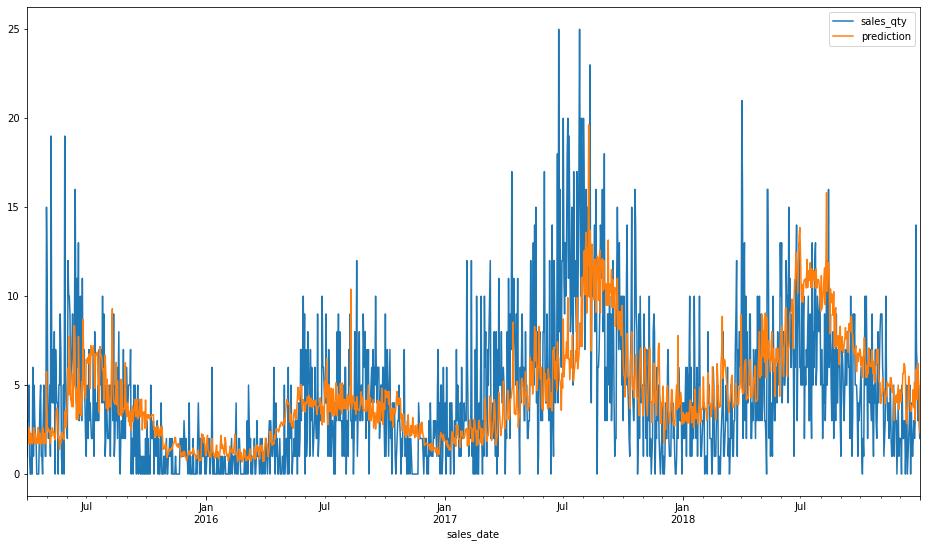

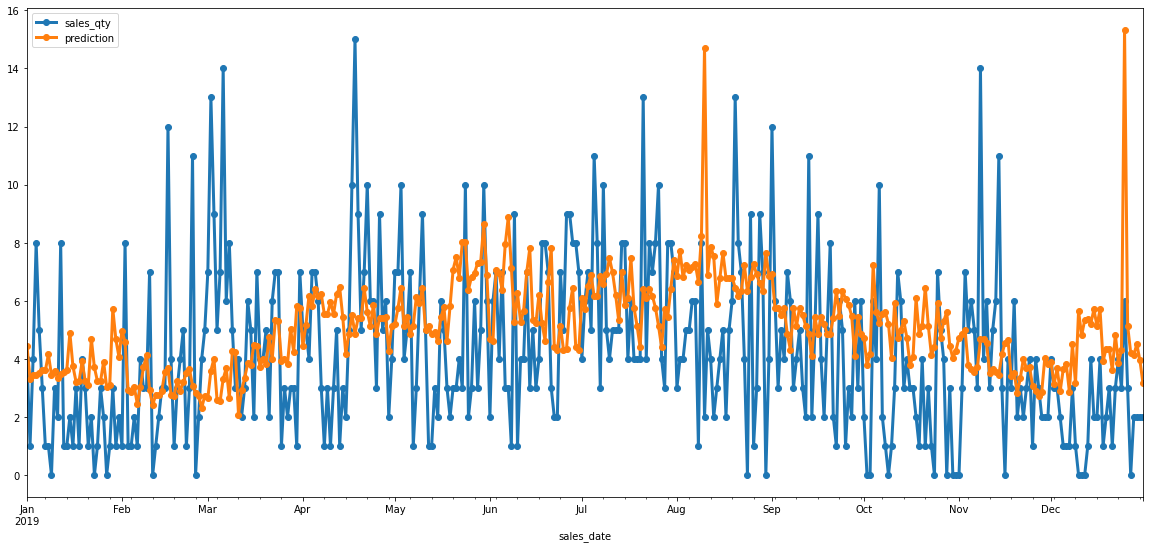

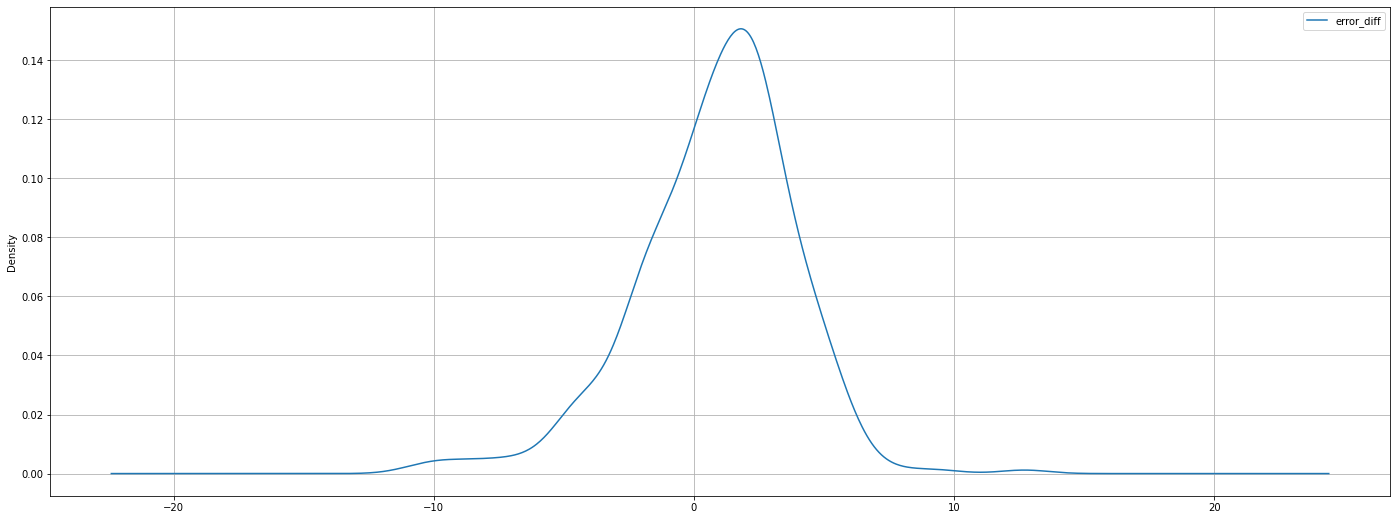

#### Item: Caj s limunom i medom ####
## Train & valid scores: 
WMAPE: 41.58
Bias: -1.1
## Test scores: 
#### Item: Niksicko pivo ####
## Train & valid scores: 
WMAPE: 64.31
Bias: -4.86
## Test scores: 
WMAPE: 72.5
Bias: 28.23


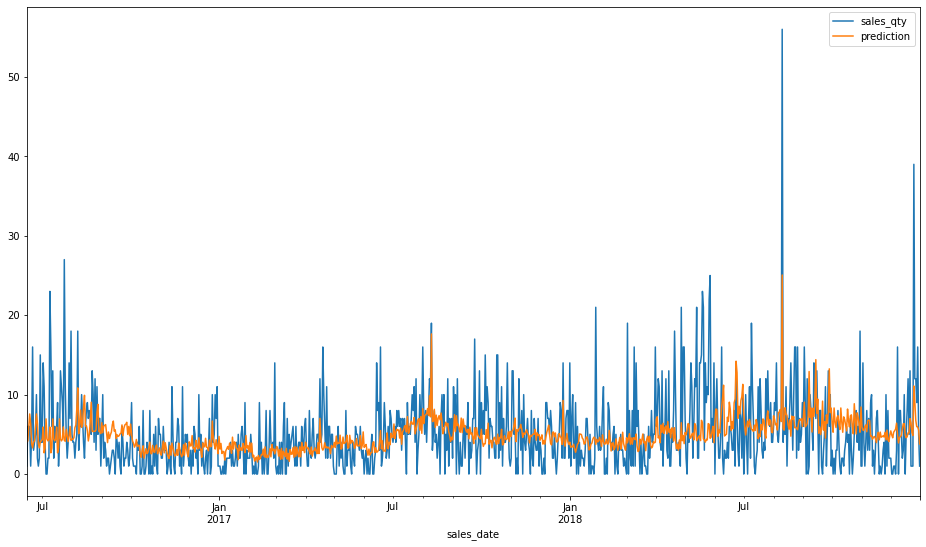

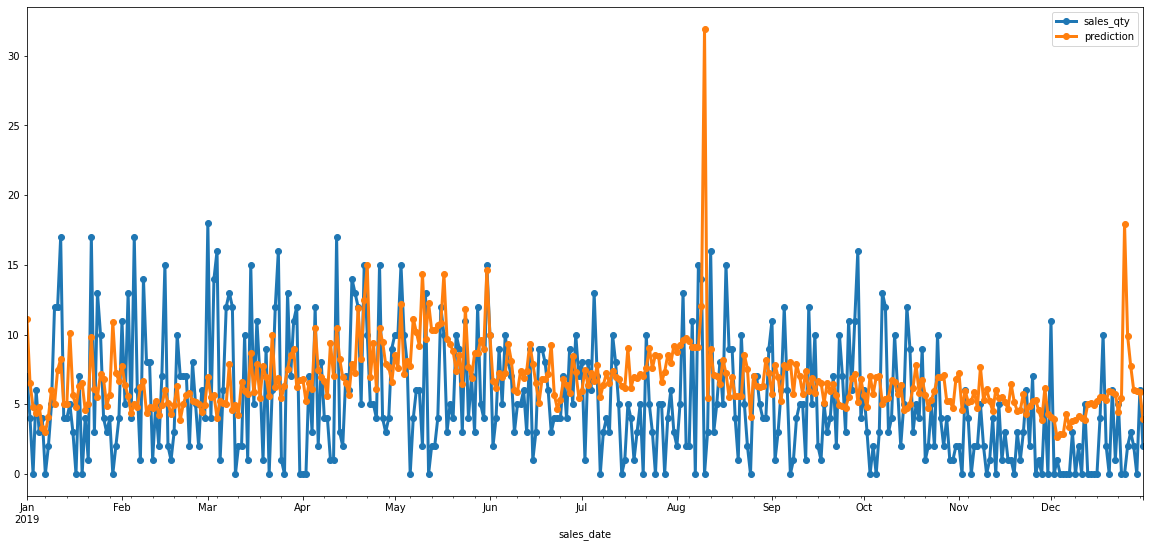

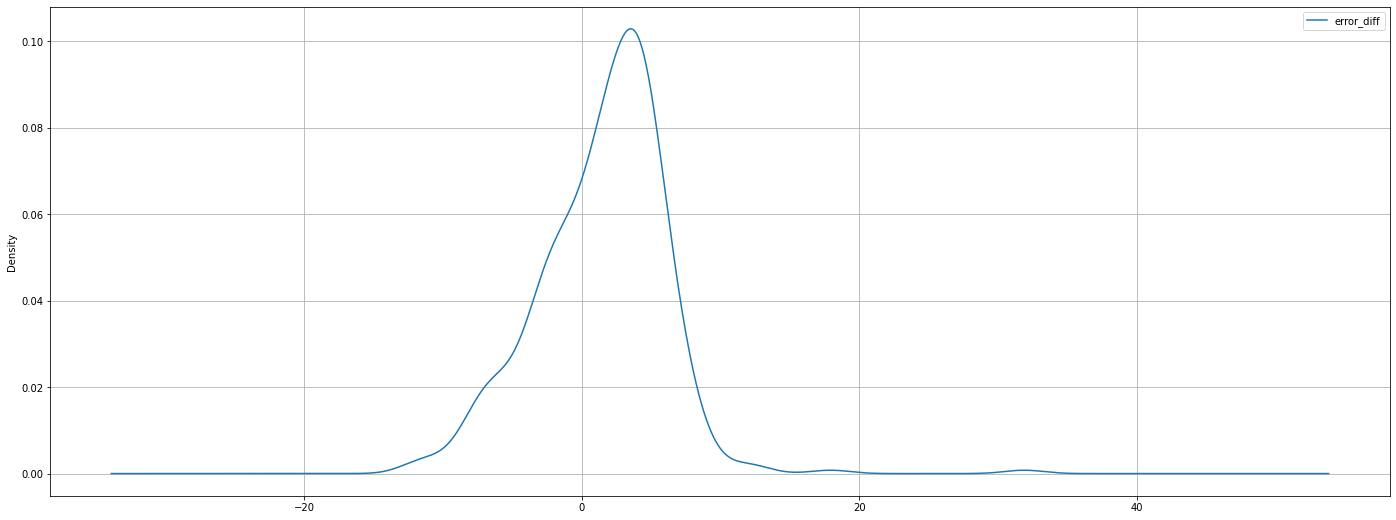

#### Item: Pipi ####
## Train & valid scores: 
WMAPE: 63.3
Bias: 5.78
## Test scores: 
WMAPE: 61.35
Bias: 19.27


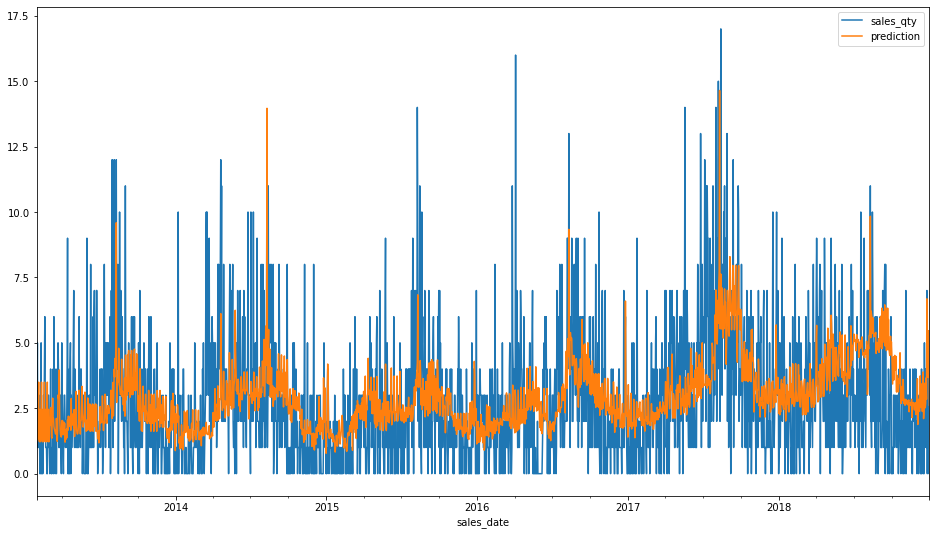

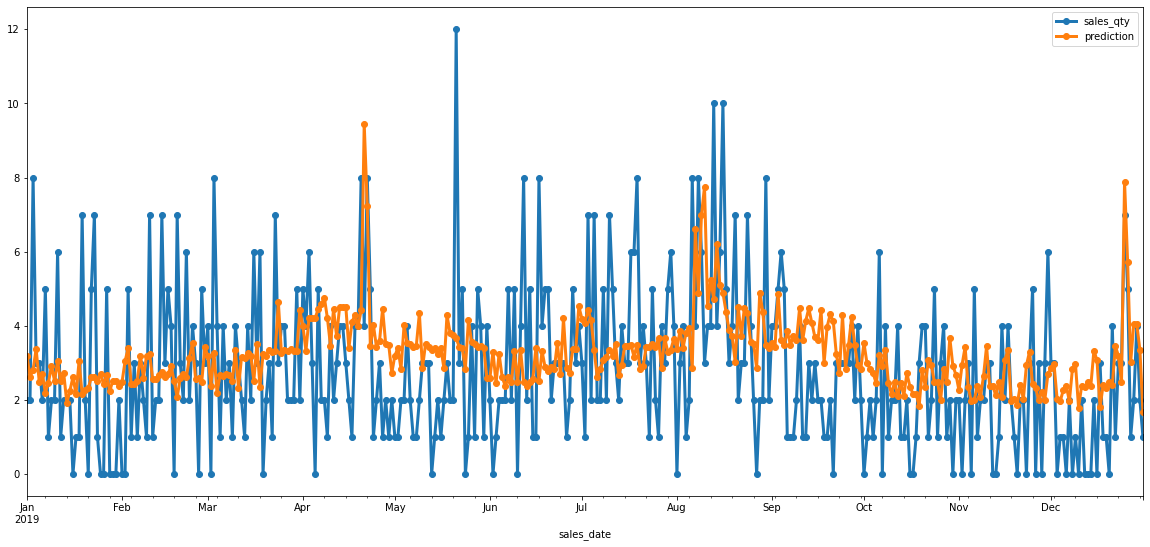

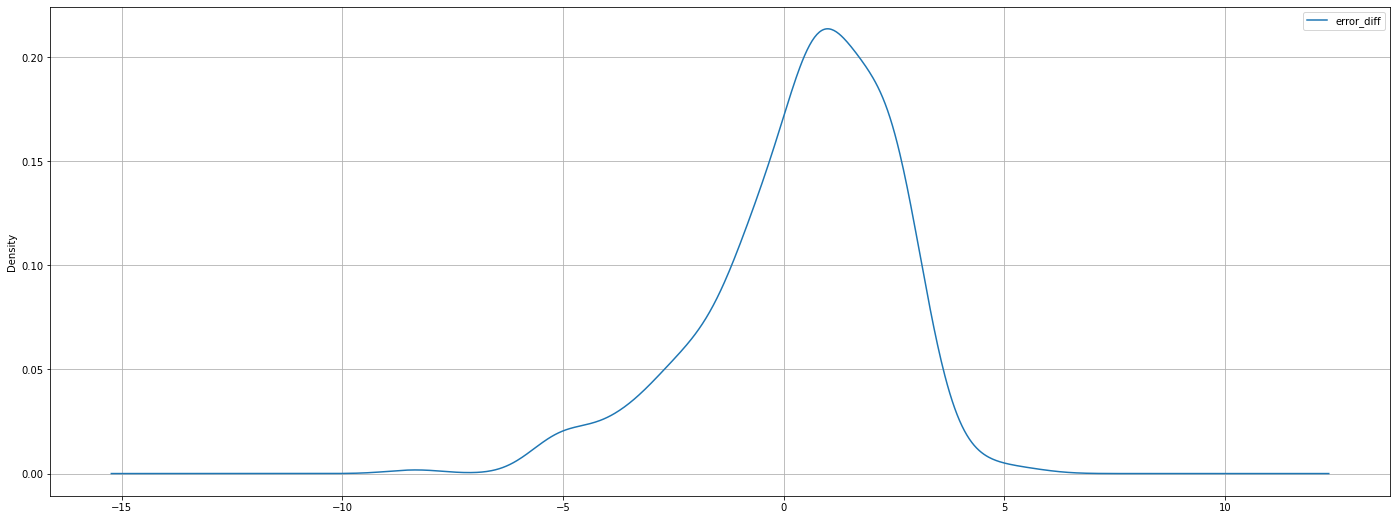

#### Item: Bijela kava ####
## Train & valid scores: 
WMAPE: 62.07
Bias: 6.67
## Test scores: 
WMAPE: 51.65
Bias: -16.1


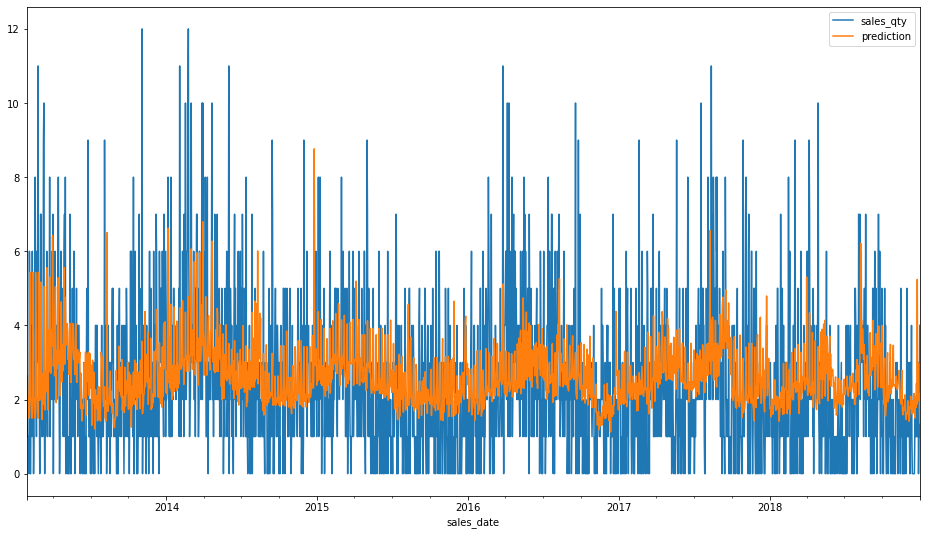

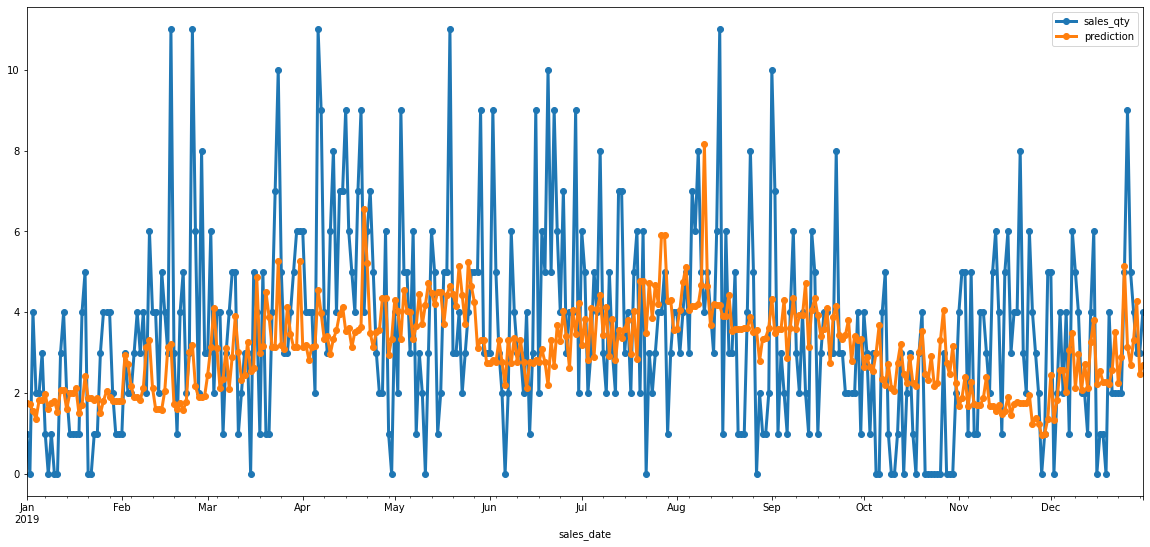

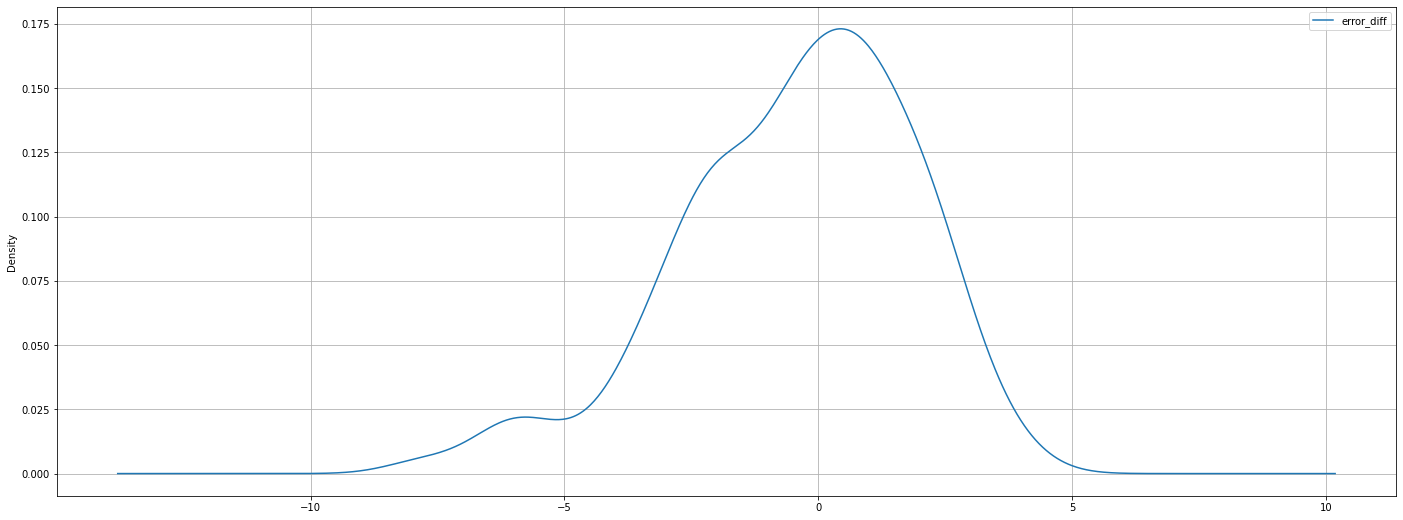

#### Item: Orahovac ####
## Train & valid scores: 
WMAPE: 90.77
Bias: -3.13
## Test scores: 
WMAPE: 83.44
Bias: 1.13


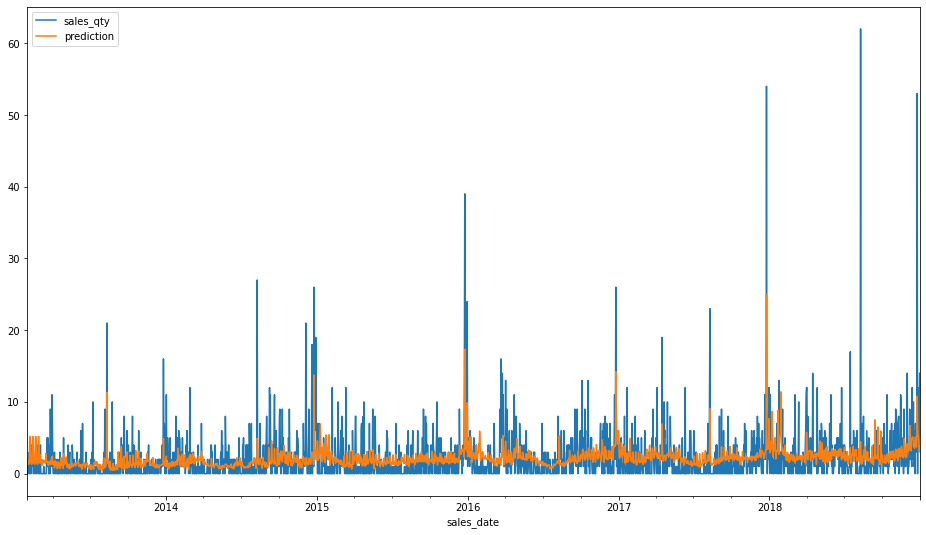

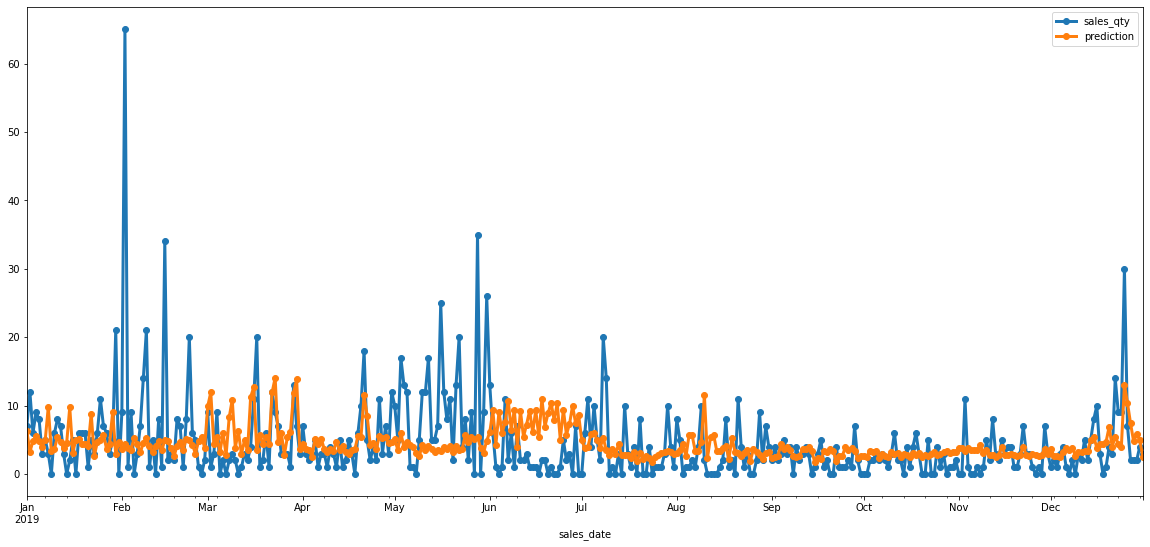

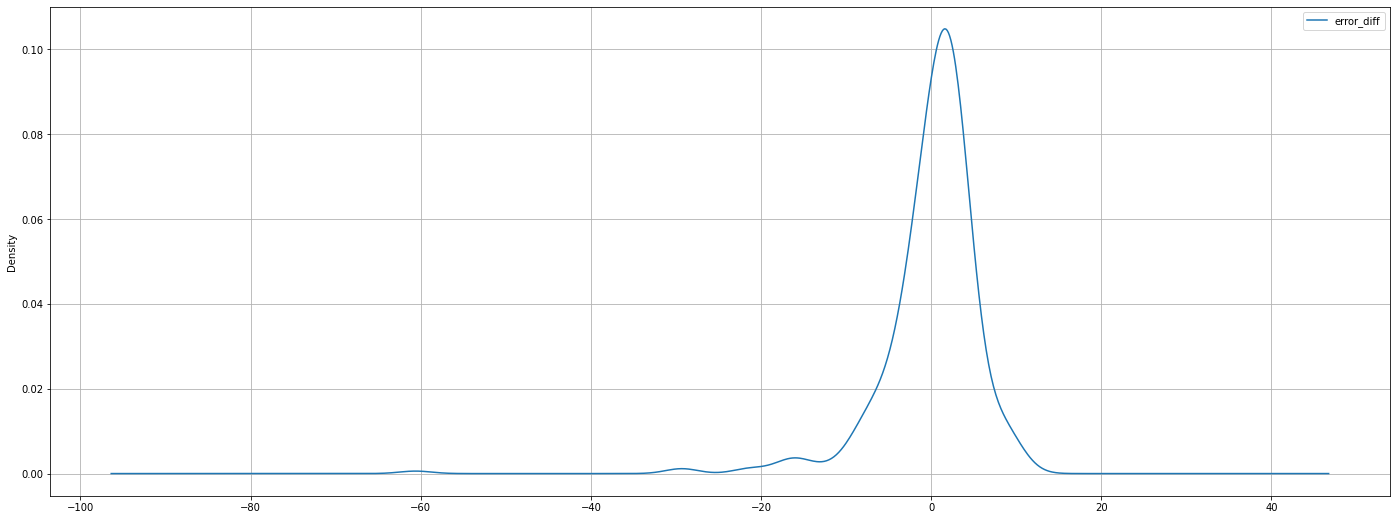

#### Item: Spezi+kava ####
## Train & valid scores: 
WMAPE: 42.68
Bias: -7.93
## Test scores: 
#### Item: Ozujsko pivo ####
## Train & valid scores: 
WMAPE: 86.68
Bias: 5.79
## Test scores: 
WMAPE: 65.87
Bias: -2.58


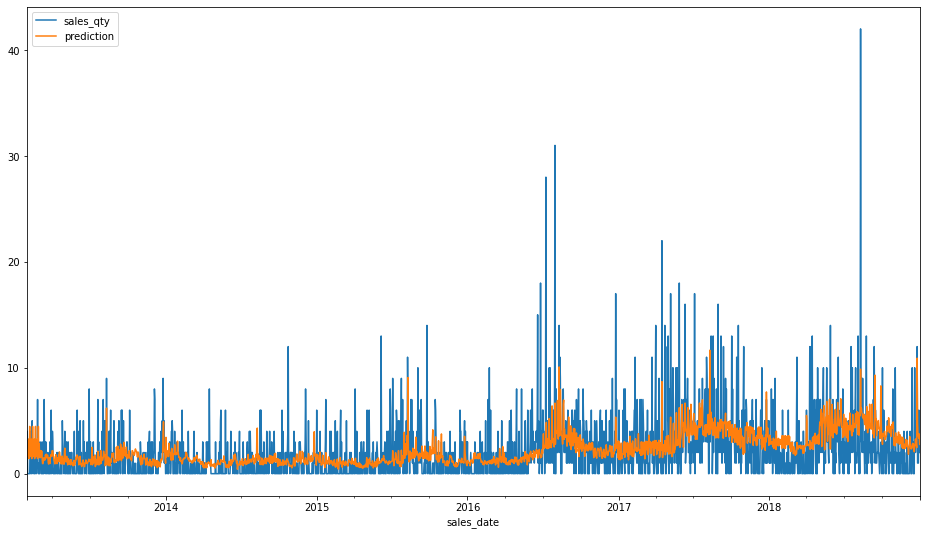

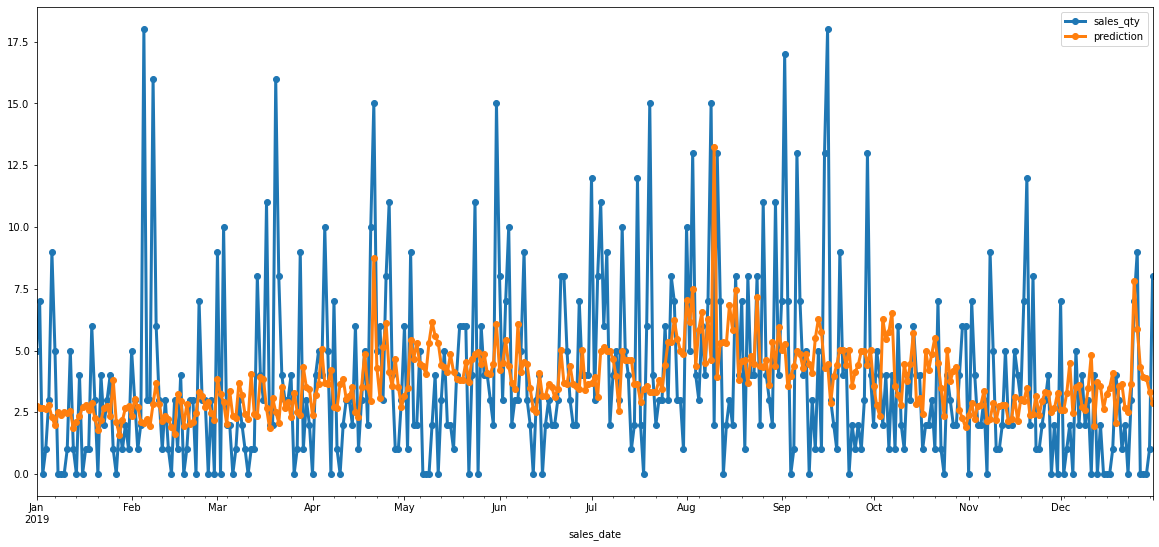

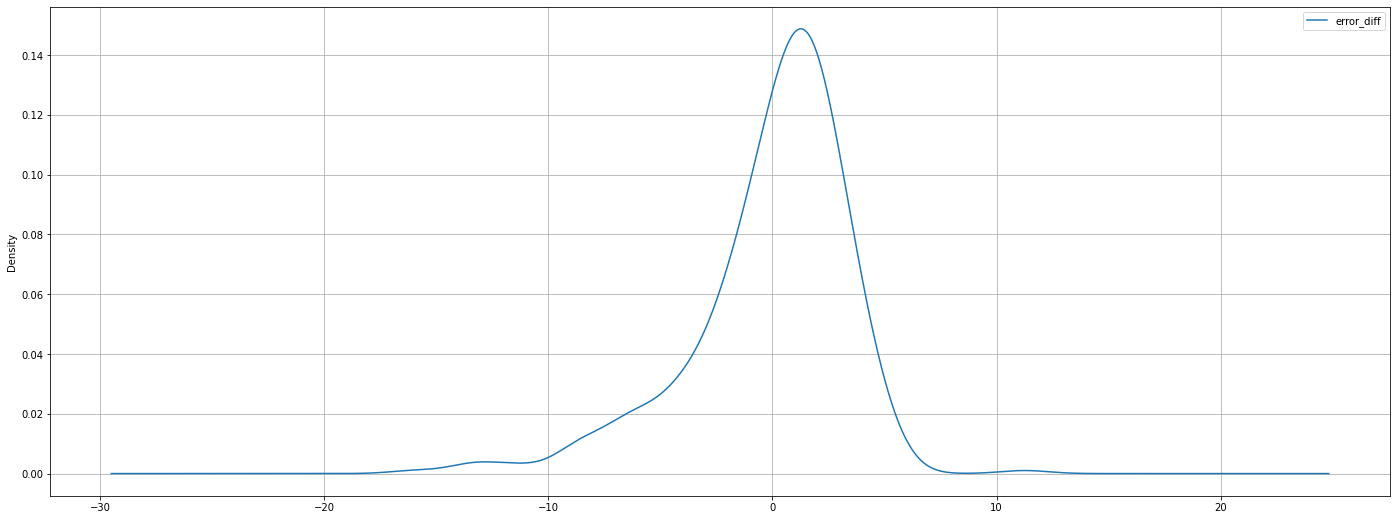

#### Item: Beck`s ####
## Train & valid scores: 
WMAPE: 83.15
Bias: -6.91
## Test scores: 
WMAPE: 71.31
Bias: -6.79


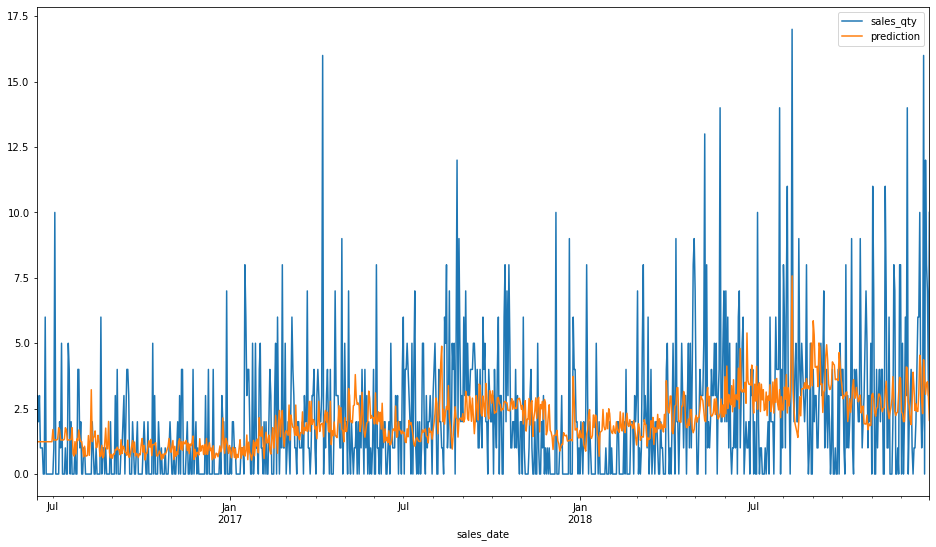

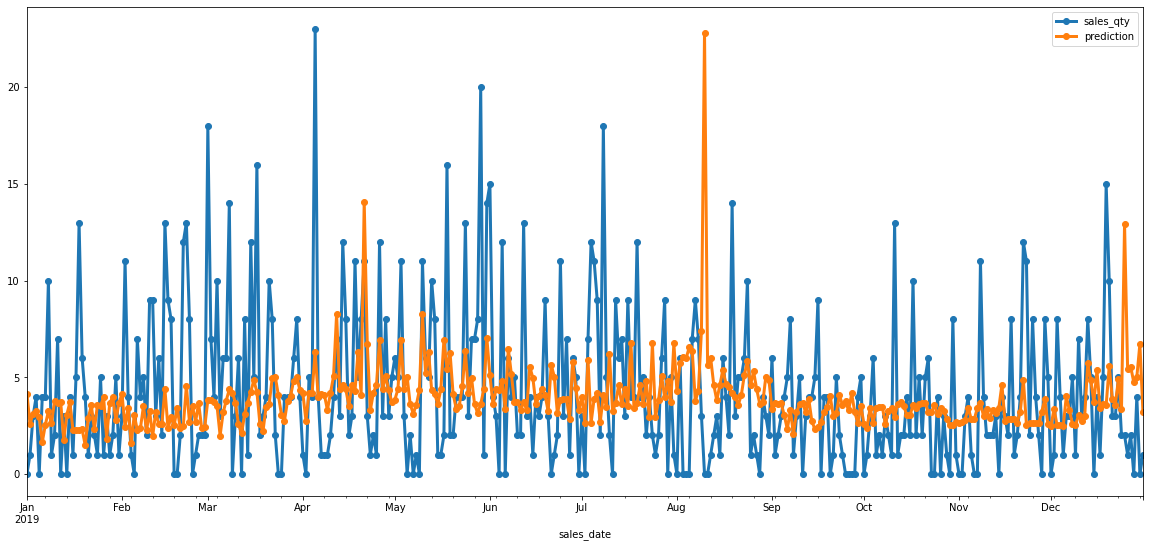

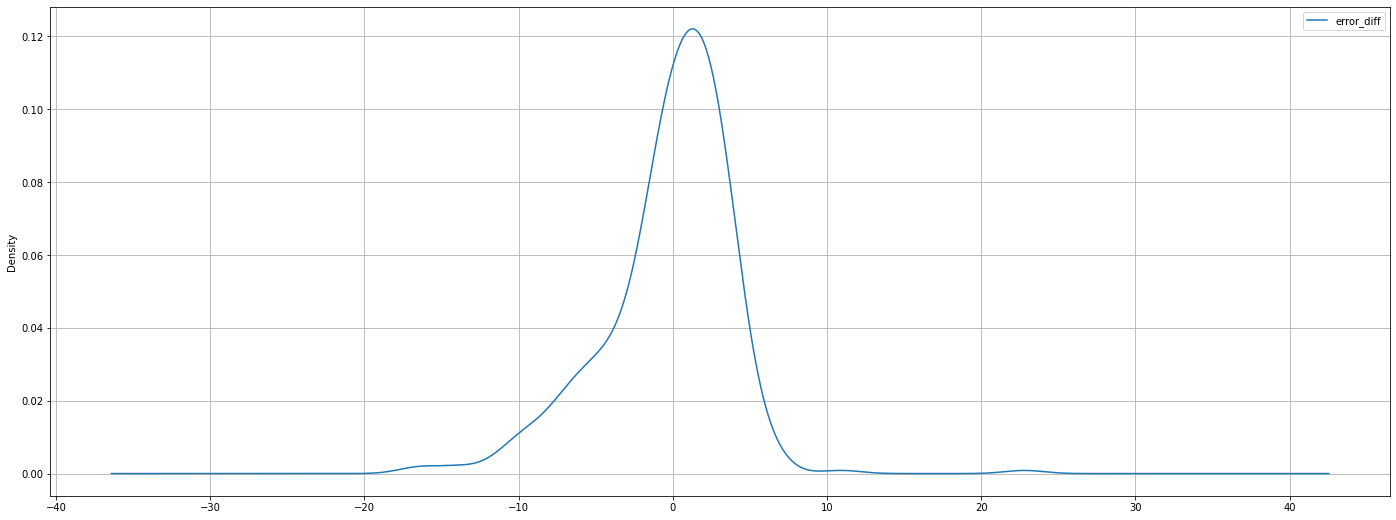

In [154]:
for item in dataset_w_feats.groupby('item_name')['sales_qty'].sum().sort_values(ascending=False).index[:20]:
    print(f"#### Item: {item} ####")
    print("## Train & valid scores: ")
    print(f"WMAPE: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'wmape'].values[0]}")
    print(f"Bias: {wmape_train_valid_scores.loc[(wmape_train_valid_scores.item_name == item), 'bias'].values[0]}")
    print("## Test scores: ")
    if not wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].empty:
        print(f"WMAPE: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].values[0]}")
        print(f"Bias: {wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'bias'].values[0]}")
        dataset_w_feats[(train_mask | valid_mask) & (dataset_w_feats.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(16,9))
        dataset_w_feats[(test_mask) & (dataset_w_feats.item_name == item)].plot(y=['sales_qty', 'prediction'], figsize=(20,9), marker='o', linewidth=3)
        dataset_w_feats[(test_mask) & (dataset_w_feats.item_name == item)].plot(y=['error_diff'], figsize=(24,9), kind='kde', grid=True)
        plt.show()

In [153]:
wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape'].empty

True

In [149]:
dataset_w_feats[(dataset_w_feats.item_name == item)].index.max()

Timestamp('2016-06-14 00:00:00+0000', tz='UTC')

In [145]:
wmape_test_scores.loc[(wmape_test_scores.item_name == item), 'wmape']

Series([], Name: wmape, dtype: float64)

# Comparison of model with short-term MA

In [114]:
ma_temp_df = dataset_w_feats[(dataset_w_feats.item_name == 'Kava s mlijekom velika') & (dataset_w_feats.index.year == 2018)].copy()

<AxesSubplot:xlabel='sales_date'>

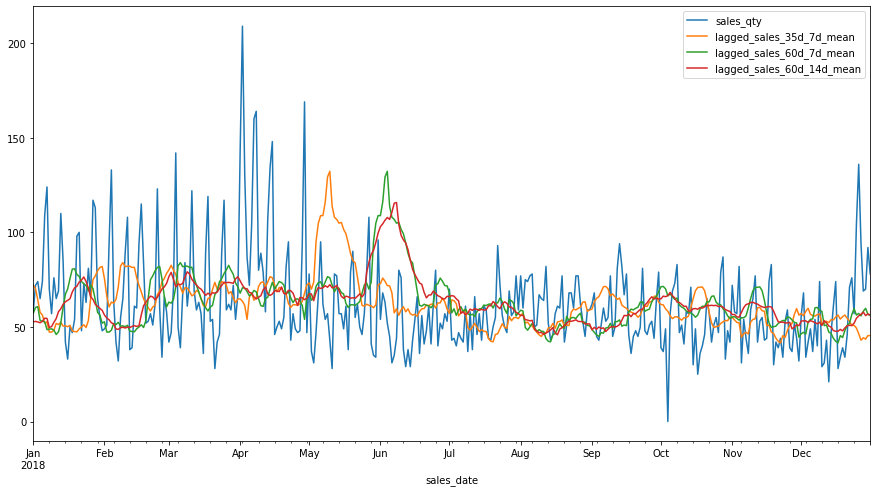

In [116]:
ma_temp_df.plot(y=['sales_qty', 'lagged_sales_35d_7d_mean', 'lagged_sales_60d_7d_mean', 'lagged_sales_60d_14d_mean'], figsize=(15,8))

In [ ]:
'lagged_sales_358d_14d_mean', 'lagged_sales_372d_14d_mean', 'lagged_sales_60d_7d_mean',
       'lagged_sales_35d_7d_mean','lagged_sales_351d_14d_mean', 'lagged_sales_379d_14d_mean',
             'lagged_sales_60d_14d_mean', 'lagged_sales_90d_7d_mean', 'lagged_sales_90d_14d_mean'

In [124]:
dataset_w_feats[['sales_qty', 'lagged_sales_358d_14d_mean', 'lagged_sales_372d_14d_mean', 'lagged_sales_60d_7d_mean',
       'lagged_sales_35d_7d_mean','lagged_sales_351d_14d_mean', 'lagged_sales_379d_14d_mean',
             'lagged_sales_60d_14d_mean', 'lagged_sales_90d_7d_mean', 'lagged_sales_90d_14d_mean']].corr()

sales_qty  lagged_sales_358d_14d_mean  \
sales_qty                    1.000000                    0.842397   
lagged_sales_358d_14d_mean   0.842397                    1.000000   
lagged_sales_372d_14d_mean   0.841107                    0.977363   
lagged_sales_60d_7d_mean     0.830359                    0.900615   
lagged_sales_35d_7d_mean     0.849494                    0.906008   
lagged_sales_351d_14d_mean   0.838877                    0.990742   
lagged_sales_379d_14d_mean   0.838868                    0.970375   
lagged_sales_60d_14d_mean    0.837231                    0.907717   
lagged_sales_90d_7d_mean     0.819597                    0.896780   
lagged_sales_90d_14d_mean    0.826607                    0.903392   

                            lagged_sales_372d_14d_mean  \
sales_qty                                     0.841107   
lagged_sales_358d_14d_mean                    0.977363   
lagged_sales_372d_14d_mean                    1.000000   
lagged_sales_60d_7d_mean                      0.904596   
lagged_sales_35d_7d_mean                      0.901140   
lagged_sales_351d_14d_mean                    0.970392   
lagged_sales_379d_14d_mean                    0.990706   
lagged_sales_60d_14d_mean                     0.911613   
lagged_sales_90d_7d_mean                      0.897439   
lagged_sales_90d_14d_mean                     0.904542   

                            lagged_sales_60d_7d_mean  \
sales_qty                                   0.830359   
lagged_sales_358d_14d_mean                  0.900615   
lagged_sales_372d_14d_mean                  0.904596   
lagged_sales_60d_7d_mean                    1.000000   
lagged_sales_35d_7d_mean                    0.928671   
lagged_sales_351d_14d_mean                  0.899273   
lagged_sales_379d_14d_mean                  0.905651   
lagged_sales_60d_14d_mean                   0.994440   
lagged_sales_90d_7d_mean                    0.920874   
lagged_sales_90d_14d_mean                   0.927379   

                            lagged_sales_35d_7d_mean  \
sales_qty                                   0.849494   
lagged_sales_358d_14d_mean                  0.906008   
lagged_sales_372d_14d_mean                  0.901140   
lagged_sales_60d_7d_mean                    0.928671   
lagged_sales_35d_7d_mean                    1.000000   
lagged_sales_351d_14d_mean                  0.905894   
lagged_sales_379d_14d_mean                  0.899913   
lagged_sales_60d_14d_mean                   0.935570   
lagged_sales_90d_7d_mean                    0.895833   
lagged_sales_90d_14d_mean                   0.902978   

                            lagged_sales_351d_14d_mean  \
sales_qty                                     0.838877   
lagged_sales_358d_14d_mean                    0.990742   
lagged_sales_372d_14d_mean                    0.970392   
lagged_sales_60d_7d_mean                      0.899273   
lagged_sales_35d_7d_mean                      0.905894   
lagged_sales_351d_14d_mean                    1.000000   
lagged_sales_379d_14d_mean                    0.965340   
lagged_sales_60d_14d_mean                     0.906396   
lagged_sales_90d_7d_mean                      0.893800   
lagged_sales_90d_14d_mean                     0.900267   

                            lagged_sales_379d_14d_mean  \
sales_qty                                     0.838868   
lagged_sales_358d_14d_mean                    0.970375   
lagged_sales_372d_14d_mean                    0.990706   
lagged_sales_60d_7d_mean                      0.905651   
lagged_sales_35d_7d_mean                      0.899913   
lagged_sales_351d_14d_mean                    0.965340   
lagged_sales_379d_14d_mean                    1.000000   
lagged_sales_60d_14d_mean                     0.912672   
lagged_sales_90d_7d_mean                      0.898456   
lagged_sales_90d_14d_mean                     0.905541   

                            lagged_sales_60d_14d_mean  \
sales_qty                                    0.837231   
lag

In [118]:
wmape_train = wmape(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['lagged_sales_60d_14d_mean'])
wmape_test = wmape(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['lagged_sales_60d_14d_mean'])

bias_train = wbias(dataset_w_feats[train_mask]['sales_qty'], dataset_w_feats[train_mask]['lagged_sales_60d_14d_mean'])
bias_test = wbias(dataset_w_feats[test_mask]['sales_qty'], dataset_w_feats[test_mask]['lagged_sales_60d_14d_mean'])

print("Train WMAPE:", wmape_train)
print("Test WMAPE:", wmape_test)
print("Train bias:", bias_train)
print("Test bias:", bias_test)

Train WMAPE: 50.57
Test WMAPE: 48.81
Train bias: -1.51
Test bias: 1.16


In [26]:
dataset.index.min()

Timestamp('2013-01-28 00:00:00+0000', tz='UTC')

In [30]:
dataset_w_feats[dataset_w_feats.index == dataset_w_feats.index.max()]

item_name  sales_qty  item_price  \
sales_date                                                                 
2020-11-27 00:00:00+00:00                  Beck`s         12        18.0   
2020-11-27 00:00:00+00:00               Budweiser         23        18.0   
2020-11-27 00:00:00+00:00                     Caj          8         9.0   
2020-11-27 00:00:00+00:00                Cedevita         15        12.0   
2020-11-27 00:00:00+00:00               Coca Cola          1        15.0   
2020-11-27 00:00:00+00:00                  Cockta          1        15.0   
2020-11-27 00:00:00+00:00                 Emotion          1        13.0   
2020-11-27 00:00:00+00:00                   Juicy          3        16.0   
2020-11-27 00:00:00+00:00                   Kakao          1        15.0   
2020-11-27 00:00:00+00:00                    Kava         12         7.0   
2020-11-27 00:00:00+00:00         Kava s mlijekom         18         8.0   
2020-11-27 00:00:00+00:00  Kava s mlijekom velika         74         9.0   
2020-11-27 00:00:00+00:00          Kava sa slagom          1         8.0   
2020-11-27 00:00:00+00:00              Ledeni caj          2        14.0   
2020-11-27 00:00:00+00:00                  Limona          1        15.0   
2020-11-27 00:00:00+00:00          Mineralna voda          3         9.0   
2020-11-27 00:00:00+00:00                Nescaffe         16        14.0   
2020-11-27 00:00:00+00:00           Niksicko pivo          8        18.0   
2020-11-27 00:00:00+00:00                Orahovac          4        12.0   
2020-11-27 00:00:00+00:00            Ozujsko pivo          8        15.0   
2020-11-27 00:00:00+00:00                    Pipi          2        15.0   
2020-11-27 00:00:00+00:00             Staropramen          6        16.0   
2020-11-27 00:00:00+00:00             Vino  0,2 l          1        25.0   
2020-11-27 00:00:00+00:00                   Vodka          2        12.0   

                           day_of_week_1  day_of_week_2  day_of_week_3  \
sales_date                                                               
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   
2020-11-27 00:00:00+00:00              0              0              0   

                           day_of_week_4  day_of_week_5  day_of_week_6  \
sales_date                                                      